# Comparative analyses of machine learning-based models
This juptyer notebook goes through the compiling, training, testing and visualisation of machine learning models used for bacterial taxonomy classification using the curated 16S rRNA sequence datasets.

## Loading modules, training variables and data

In [ ]:
# LOADING PACKAGES
import numpy as np
import pandas as pd
import sys
from varname import argname
import time
import os
import glob
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Masking, Dot, Add, BatchNormalization
from keras.layers import MaxPooling1D, AveragePooling1D, Conv1D, Reshape
from keras.layers import TimeDistributed, LSTM, Bidirectional

# hypervariables for training
LR, BATCH_SIZE, EPOCHS, = 0.001, 128, 60
# input shape for RNNs is dependent on sequence cut-off length
MAX_LEN, INPUT_SHAPE_RNN = 2000, (2000, 4)
# input shape for CNNs is dependent on size and amount of k-mer (n^k)
INPUT_SHAPE_3_MER, INPUT_SHAPE_5_MER = (4**3, 1), (4**5, 1)
INPUT_SHAPE_7_MER, INPUT_SHAPE_8_MER = (4**7, 1), (4**8, 1)
INPUT_SHAPE_5_MER_N, INPUT_SHAPE_7_MER_N = (5**5, 1), (5**7, 1)

print('Packages loaded!')

In [ ]:
# LOADING THE NON-AUGMENTED AND AUGMENTED DATASETS
train_na = pd.read_csv('df_train_0.csv')
val_na = pd.read_csv('df_val_0.csv')
test_na = pd.read_csv('df_test_0.csv')
# ------------------------------------------------
train_a = pd.read_csv('df_train_1.csv')
val_a = pd.read_csv('df_val_1.csv')
# ------------------------------------------------
print('Datasets loaded!')

## Defining functions for encoding the data

### K-mer encoding the sequences
For use in the Convolutional Neural Networks (CNN), the sequences are processed into a frequency table of k-mers.

In [ ]:
from itertools import product
# define all possible k-mers
alphabet = "AGTC"
alphabet_wN = "AGTCN"
tri_mers = [''.join(chars) for chars in product(*(3*(alphabet,)))]
fiv_mers = [''.join(chars) for chars in product(*(5*(alphabet,)))]
sev_mers = [''.join(chars) for chars in product(*(7*(alphabet,)))]
eig_mers = [''.join(chars) for chars in product(*(8*(alphabet,)))]
fiv_mers_wN = [''.join(chars) for chars in product(*(5*(alphabet_wN,)))]
sev_mers_wN = [''.join(chars) for chars in product(*(7*(alphabet_wN,)))]

def one_hot_k(sequence, kmers):
    k = len(kmers[0])
    with_N = 'N' in kmers[-1]
    # define a counter dictionary
    kmer_dict = dict.fromkeys(kmers, 0)

    # standardize the sequence
    # by replacing U with T, and all ambiguous bases with N
    sequence = sequence.replace('U', 'T').replace('Y', 'N').replace('R', 'N').replace('W', 'N').replace('S', 'N').replace('K', 'N').replace('M', 'N').replace('D', 'N').replace('V', 'N').replace('H', 'N').replace('B', 'N').replace('X', 'N').replace('-', 'N')
    # count every k-mer in the sequence
    for i in range(0, len(sequence) - k+1):
        k_mer = sequence[i:i+k]
        if with_N:
            kmer_dict[k_mer] += 1
        else:
            if 'N' not in k_mer:
                kmer_dict[k_mer] += 1

    # k-mer frequency array from the dictionary values
    k_array = np.array(list(kmer_dict.values()))
    return k_array

### One-hot-encoding the sequences
For use in the various Recurrent Neural Networks (RNN), the nucleotide sequences are processed into a one-hot-encoded format.

In [ ]:
# Dictionary without consideration of mutation rate
one_hot_dict0 = {
    'A': [1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'T':[0.,0.,1.,0.], 'U':[0.,0.,1.,0.], 'C':[0.,0.,0.,1.], 
    'Y':[0.,0.,0.5,0.5], 'R':[0.5,0.5,0.,0.], 'W':[0.5,0.,0.5,0.], 'S':[0.,0.5,0.,0.5], 'K':[0.,0.5,0.5,0.], 'M':[0.5,0.,0.,0.5], 
    'D':[0.33,0.33,0.33,0.], 'V':[0.33,0.33,0.,0.33], 'H':[0.33,0.,0.33,0.33], 'B':[0.,0.33,0.33,0.33], 
    'X':[0.25,0.25,0.25,0.25], 'N':[0.25,0.25,0.25,0.25], '-':[0.,0.,0.,0.]
    }
# Dictionary with consideration of mutation rate (transition > transversion)
one_hot_dict1 = {
    'A': [1.,0.,-0.5,-0.5], 'G':[0.,1.,-0.5,-0.5], 'T':[-0.5,-0.5,1.,0.], 'U':[-0.5,-0.5,1.,0.], 'C':[-0.5,-0.5,0.,1.], 
    'Y':[-0.5,-0.5,0.5,0.5], 'R':[0.5,0.5,-0.5,-0.5], 'W':[0.5,-0.5,0.5,-0.5], 'S':[-0.5,0.5,-0.5,0.5], 'K':[-0.5,0.5,0.5,-0.5], 'M':[0.5,-0.5,-0.5,0.5], 
    'D':[0.33,0.33,0.33,-1.], 'V':[0.33,0.33,-1.,0.33], 'H':[0.33,-1.,.33,0.33], 'B':[-1.,0.33,0.33,0.33], 
    'X':[0.,0.,0.,0.], 'N':[0.,0.,0.,0.], '-':[0.,0.,0.,0.]
    }
# Dictionary with consideration of mutation rate (transition >>> transversion)
one_hot_dict2 = {
    'A': [1.,0.,-1.,-1.], 'G':[0.,1.,-1.,-1.], 'T':[-1.,-1.,1.,0.], 'U':[-1.,-1.,1.,0.], 'C':[-1.,-1.,0.,1.], 
    'Y':[-0.5,-0.5,0.5,0.5], 'R':[0.5,0.5,-0.5,-0.5], 'W':[0.5,-0.5,0.5,-0.5], 'S':[-0.5,0.5,-0.5,0.5], 'K':[-0.5,0.5,0.5,-0.5], 'M':[0.5,-0.5,-0.5,0.5], 
    'D':[0.33,0.33,0.33,-.33], 'V':[0.33,0.33,-0.33,0.33], 'H':[0.33,-0.33,.33,0.33], 'B':[-0.33,0.33,0.33,0.33], 
    'X':[0.,0.,0.,0.], 'N':[0.,0.,0.,0.], '-':[0.,0.,0.,0.]
    }

def one_hot_seq(sequence, one_hot_dict, max_len):
    # padding the sequences to a fixed length
	sequence += '-'*(max_len - len(sequence))
    # generating list of one-hot-lists using the dictionary
	onehot_encoded = [one_hot_dict[nucleotide] for nucleotide in sequence]
    # returning the list of lists as a numpy array
	return np.array(onehot_encoded)

### One-hot-encoding the labels
For use in the deep learning models, the labels are processed into a one-hot-encoding format. To achieve this, every unique label is first encoded to a numerical value.

In [ ]:
def get_taxon_dict(df, taxon):
    # listing all unique taxon labels
    taxon_list = list(df[taxon].unique())

    # generating a dictionary to associate every unique taxon to a number
    taxon_dict = dict(zip(taxon_list, range(0, len(taxon_list))))
    # and the reversed dictionary as a lookup table
    taxon_dict_lookup = {v: k for k, v in taxon_dict.items()}

    return taxon_dict, taxon_dict_lookup

## Generating the input sequences and labels
The encoding methods for nucleotide sequences (x) defined earlier are now applied. The labels (y) are one-hot-encoded using the to_categorical function in keras_utils, thereby, converting the data into the correct format for feeding it to the deep learning models.

Every array is saved to reduce memory requirements down the road.

### Encoding the sequences into k-mer counts and one-hot-encoded sequences

In [ ]:
# ENCODING SEQUENCES for the CNN models in 3 processing variations
# FOR CNN  |  with 3-mer encoding
x_train_CNN_na3 = np.array(
    train_na['Sequence'].apply(lambda x: one_hot_k(x, tri_mers)).tolist())
np.save('arrays/CNN/x_train_CNN_na3.npy', x_train_CNN_na3)

x_test_CNN_na3 = np.array(
    test_na['Sequence'].apply(lambda x: one_hot_k(x, tri_mers)).tolist())
np.save('arrays/CNN/x_test_CNN_na3.npy', x_test_CNN_na3)

dataval_CNN_na3 = np.array(
    val_na['Sequence'].apply(lambda x: one_hot_k(x, tri_mers)).tolist())
np.save('arrays/CNN/dataval_CNN_na3.npy', dataval_CNN_na3)
print('3-mer encoding complete')
# -----------------------------------------------------------------------------------------------------
# FOR CNN  |  with 5-mer encoding
x_train_CNN_na5 = np.array(
    train_na['Sequence'].apply(lambda x: one_hot_k(x, fiv_mers)).tolist())
np.save('arrays/CNN/x_train_CNN_na5.npy', x_train_CNN_na5)

x_test_CNN_na5 = np.array(
    test_na['Sequence'].apply(lambda x: one_hot_k(x, fiv_mers)).tolist())
np.save('arrays/CNN/x_test_CNN_na5.npy', x_test_CNN_na5)

dataval_CNN_na5 = np.array(
    val_na['Sequence'].apply(lambda x: one_hot_k(x, fiv_mers)).tolist())
np.save('arrays/CNN/dataval_CNN_na5.npy', dataval_CNN_na5)
print('5-mer encoding complete')
# -----------------------------------------------------------------------------------------------------
# FOR CNN  |  with 7-mer encoding (also for the augmented data)
x_train_CNN_na7 = np.array(
    train_na['Sequence'].apply(lambda x: one_hot_k(x, sev_mers)).tolist())
np.save('arrays/CNN/x_train_CNN_na7.npy', x_train_CNN_na7)

x_train_CNN_a7 = np.array(
    train_a['Sequence'].apply(lambda x: one_hot_k(x, sev_mers)).tolist())
np.save('arrays/CNN/x_train_CNN_a7.npy', x_train_CNN_a7)

x_test_CNN_na7 = np.array(
    test_na['Sequence'].apply(lambda x: one_hot_k(x, sev_mers)).tolist())
np.save('arrays/CNN/x_test_CNN_na7.npy', x_test_CNN_na7)

dataval_CNN_na7 = np.array(
    val_na['Sequence'].apply(lambda x: one_hot_k(x, sev_mers)).tolist())
np.save('arrays/CNN/dataval_CNN_na7.npy', dataval_CNN_na7)

dataval_CNN_a7 = np.array(
    val_a['Sequence'].apply(lambda x: one_hot_k(x, sev_mers)).tolist())
np.save('arrays/CNN/dataval_CNN_a7.npy', dataval_CNN_a7)
print('7-mer encoding complete')
# -----------------------------------------------------------------------------------------------------
# FOR CNN  |  with 8-mer encoding
x_train_CNN_na8 = np.array(
    train_na['Sequence'].apply(lambda x: one_hot_k(x, eig_mers)).tolist())
np.save('arrays/CNN/x_train_CNN_na8.npy', x_train_CNN_na8)

x_test_CNN_na8 = np.array(
    test_na['Sequence'].apply(lambda x: one_hot_k(x, eig_mers)).tolist())
np.save('arrays/CNN/x_test_CNN_na8.npy', x_test_CNN_na8)

dataval_CNN_na8 = np.array(
    val_na['Sequence'].apply(lambda x: one_hot_k(x, eig_mers)).tolist())
np.save('arrays/CNN/dataval_CNN_na8.npy', dataval_CNN_na8)
print('8-mer encoding complete')
# -----------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------
# FOR CNN  |  with 5 and 7-mer encoding including ambiguous bases (N)
x_train_CNN_na5N = np.array(
    train_na['Sequence'].apply(lambda x: one_hot_k(x, fiv_mers_wN)).tolist())
np.save('arrays/CNN/x_train_CNN_na5N.npy', x_train_CNN_na5N)

x_test_CNN_na5N = np.array(
    test_na['Sequence'].apply(lambda x: one_hot_k(x, fiv_mers_wN)).tolist())
np.save('arrays/CNN/x_test_CNN_na5N.npy', x_test_CNN_na5N)

dataval_CNN_na5N = np.array(
    val_na['Sequence'].apply(lambda x: one_hot_k(x, fiv_mers_wN)).tolist())
np.save('arrays/CNN/dataval_CNN_na5N.npy', dataval_CNN_na5N)
print('5-mer encoding, including N complete')
# -----------------------------------------------------------------------------------------------------
x_train_CNN_na7N = np.array(
    train_na['Sequence'].apply(lambda x: one_hot_k(x, sev_mers_wN)).tolist())
np.save('arrays/CNN/x_train_CNN_na7N.npy', x_train_CNN_na7N)

x_test_CNN_na7N = np.array(
    test_na['Sequence'].apply(lambda x: one_hot_k(x, sev_mers_wN)).tolist())
np.save('arrays/CNN/x_test_CNN_na7N.npy', x_test_CNN_na7N)

dataval_CNN_na7N = np.array(
    val_na['Sequence'].apply(lambda x: one_hot_k(x, sev_mers_wN)).tolist())
np.save('arrays/CNN/dataval_CNN_na7N.npy', dataval_CNN_na7N)
print('7-mer encoding, including N complete')
# -----------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------
print('CNN sequences complete')

In [ ]:
# ENCODING SEQUENCES for the RNN models in 3 processing variations
# FOR RNN  |  with regular one-hot-encoding
x_train_RNN_na0 = np.array(
    train_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict0, max_len = MAX_LEN)).tolist())
np.save('arrays/RNN/x_train_RNN_na0.npy', x_train_RNN_na0)

x_test_RNN_na0 = np.array(
    test_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict0, max_len = MAX_LEN)).tolist())
np.save('arrays/RNN/x_test_RNN_na0.npy', x_test_RNN_na0)

dataval_RNN_na0 = np.array(
    val_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict0, max_len = MAX_LEN)).tolist())
np.save('arrays/RNN/dataval_RNN_na0.npy', dataval_RNN_na0)
print('Regular one-hot-encoding complete')
# -----------------------------------------------------------------------------------------------------
# FOR RNN  |  with matation rate adjusted one-hot-encoding (with augmented data)
x_train_RNN_na1 = np.array(
    train_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict1, max_len = MAX_LEN)).tolist())
np.save('arrays/RNN/x_train_RNN_na1.npy', x_train_RNN_na1)

x_train_RNN_a1 = np.array(
    train_a['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict1, max_len = MAX_LEN)).tolist())
np.save('arrays/RNN/x_train_RNN_a1.npy', x_train_RNN_a1)

x_test_RNN_na1 = np.array(
    test_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict1, max_len = MAX_LEN)).tolist())
np.save('arrays/RNN/x_test_RNN_na1.npy', x_test_RNN_na1)

dataval_RNN_na1 = np.array(
    val_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict1, max_len = MAX_LEN)).tolist())
np.save('arrays/RNN/dataval_RNN_na1.npy', dataval_RNN_na1)

dataval_RNN_a1 = np.array(
    val_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict1, max_len = MAX_LEN)).tolist())
np.save('arrays/RNN/dataval_RNN_a1.npy', dataval_RNN_a1)
print('Mutation rate adjusted one-hot-encoding complete')
# -----------------------------------------------------------------------------------------------------
# FOR RNN  |  with extra matation rate adjusted one-hot-encoding (with augmented data)
x_train_RNN_na2 = np.array(
    train_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict2, max_len = MAX_LEN)).tolist())
np.save('arrays/RNN/x_train_RNN_na2.npy', x_train_RNN_na2)

x_train_RNN_a2 = np.array(
    train_a['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict2, max_len = MAX_LEN)).tolist())
np.save('arrays/RNN/x_train_RNN_a2.npy', x_train_RNN_a2)

x_test_RNN_na2 = np.array(
    test_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict2, max_len = MAX_LEN)).tolist())
np.save('arrays/RNN/x_test_RNN_na2.npy', x_test_RNN_na2)

dataval_RNN_na2 = np.array(
    val_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict2, max_len = MAX_LEN)).tolist())
np.save('arrays/RNN/dataval_RNN_na2.npy', dataval_RNN_na2)

dataval_RNN_a2 = np.array(
    val_a['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict2, max_len = MAX_LEN)).tolist())
np.save('arrays/RNN/dataval_RNN_a2.npy', dataval_RNN_a2)
print('Extra mutation rate adjusted one-hot-encoding complete')
# -----------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------
print('RNN sequences complete')

### Encoding the labels into a one-hot-encoded format at Family level

In [ ]:
taxon = 'Family'
taxon_dict = get_taxon_dict(test_na, taxon)[0]
# -----------------------------------------------------------------------------
# Associate every entry's label in the df to a number using the dictionary 
#   & one-hot encode the numerical labels
#   & save the result as a numpy array
y_train_fam_na = to_categorical(
    y = train_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/family/y_train_fam_na.npy', y_train_fam_na)

y_test_fam_na = to_categorical(
    y = test_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/family/y_test_fam_na.npy', y_test_fam_na)

labelsval_fam_na = to_categorical(
    y = val_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/family/labelsval_fam_na.npy', labelsval_fam_na)
print('Family label arrays generated')
# -----------------------------------------------------------------------------
fam_count = train_na[taxon].nunique()
print(f'The number of unique family labels: {fam_count}')

### Encoding the labels into a one-hot-encoded format at Genus level

In [ ]:
taxon = 'Genus'
taxon_dict = get_taxon_dict(test_na, taxon)[0]
# -----------------------------------------------------------------------------
# also with augmeted data
y_train_gen_na = to_categorical(
    y = train_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/genus/y_train_gen_na.npy', y_train_gen_na)

y_train_gen_a = to_categorical(
    y = train_a[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/genus/y_train_gen_a.npy', y_train_gen_a)

y_test_gen_na = to_categorical(
    y = test_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/genus/y_test_gen_na.npy', y_test_gen_na)

labelsval_gen_na = to_categorical(
    y = val_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/genus/labelsval_gen_na.npy', labelsval_gen_na)

labelsval_gen_a = to_categorical(
    y = val_a[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/genus/labelsval_gen_a.npy', labelsval_gen_a)
print('Genus label arrays generated')
# -----------------------------------------------------------------------------
gen_count = train_na[taxon].nunique()
print(f'The number of unique genus labels: {gen_count}')

### Encoding the labels into a one-hot-encoded format at Species level

In [ ]:
taxon = 'Species'
taxon_dict = get_taxon_dict(test_na, taxon)[0]
# -----------------------------------------------------------------------------
y_train_spe_na = to_categorical(
    y = train_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/species/y_train_spe_na.npy', y_train_spe_na)

y_test_spe_na = to_categorical(
    y = test_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/species/y_test_spe_na.npy', y_test_spe_na)

labelsval_spe_na = to_categorical(
    y = val_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/species/labelsval_spe_na.npy', labelsval_spe_na)
print('Species label arrays generated')
# -----------------------------------------------------------------------------
spe_count = train_na[taxon].nunique()
print(f'The number of unique species labels: {spe_count}')

## Loading the generated training/validation/testing arrays
When seperating the processing and training/evaluation scripts, due to memory limits, the saved arrays can be loaded using this script.

In [ ]:
# AMOUNT OF UNIQUE LABELS AT EACH TAXON LEVEL
fam_count, gen_count, spe_count = 349, 954, 1569
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# LOADING ENCODED SEQUENCES for the CNN models 
# in 3 processing variations (3-, 5-, 7, 8-mer)
# FOR CNN  |  with 3-mer
x_train_CNN_na3 = np.load('arrays/CNN/x_train_CNN_na3.npy')
x_test_CNN_na3 = np.load('arrays/CNN/x_test_CNN_na3.npy')
dataval_CNN_na3 = np.load('arrays/CNN/dataval_CNN_na3.npy')
print('3-mer encoded sequences LOADED')
# -----------------------------------------------------------------------------
# FOR CNN  |  with 5-mer
x_train_CNN_na5 = np.load('arrays/CNN/x_train_CNN_na5.npy')
x_test_CNN_na5 = np.load('arrays/CNN/x_test_CNN_na5.npy')
dataval_CNN_na5 = np.load('arrays/CNN/dataval_CNN_na5.npy')
print('5-mer encoded sequences LOADED')
# -----------------------------------------------------------------------------
# FOR CNN  |  with 7-mer
x_train_CNN_na7 = np.load('arrays/CNN/x_train_CNN_na7.npy')
x_train_CNN_a7 = np.load('arrays/CNN/x_train_CNN_a7.npy')
x_test_CNN_na7 = np.load('arrays/CNN/x_test_CNN_na7.npy')
dataval_CNN_na7 = np.load('arrays/CNN/dataval_CNN_na7.npy')
dataval_CNN_a7 = np.load('arrays/CNN/dataval_CNN_a7.npy')
print('7-mer encoded sequences LOADED')
# -----------------------------------------------------------------------------
# FOR CNN  |  with 8-mer
x_train_CNN_na8 = np.load('arrays/CNN/x_train_CNN_na8.npy')
x_test_CNN_na8 = np.load('arrays/CNN/x_test_CNN_na8.npy')
dataval_CNN_na8 = np.load('arrays/CNN/dataval_CNN_na8.npy')
print('8-mer encoded sequences LOADED')
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# FOR CNN  |  with 5-mer including ambigous bases
x_train_CNN_na5N = np.load('arrays/CNN/x_train_CNN_na5N.npy')
x_test_CNN_na5N = np.load('arrays/CNN/x_test_CNN_na5N.npy')
dataval_CNN_na5N = np.load('arrays/CNN/dataval_CNN_na5N.npy')
print('5-mer encoded sequences, ignoring N bases LOADED')
# -----------------------------------------------------------------------------
# FOR CNN  |  with 7-mer including ambigous bases
x_train_CNN_na7N = np.load('arrays/CNN/x_train_CNN_na7N.npy')
x_test_CNN_na7N = np.load('arrays/CNN/x_test_CNN_na7N.npy')
dataval_CNN_na7N = np.load('arrays/CNN/dataval_CNN_na7N.npy')
print('7-mer encoded sequences, ignoring N bases LOADED')
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
print('CNN sequences LOADED')

###############################################################################

# LOADING ENCODED SEQUENCES for the RNN models in 3 processing variations
# FOR RNN  |  with regular one-hot-encoding
x_train_RNN_na0 = np.load('arrays/RNN/x_train_RNN_na0.npy')
x_test_RNN_na0 = np.load('arrays/RNN/x_test_RNN_na0.npy')
dataval_RNN_na0 = np.load('arrays/RNN/dataval_RNN_na0.npy')
print('Regular one-hot-encoded sequences LOADED')
# -----------------------------------------------------------------------------
# FOR RNN  |  with matation rate adjusted one-hot-encoding
x_train_RNN_na1 = np.load('arrays/RNN/x_train_RNN_na1.npy')
x_test_RNN_na1 = np.load('arrays/RNN/x_test_RNN_na1.npy')
dataval_RNN_na1 = np.load('arrays/RNN/dataval_RNN_na1.npy')
print('Mutation rate adjusted one-hot-encoded sequences LOADED')
# -----------------------------------------------------------------------------
# FOR RNN  |  with extra matation rate adjusted one-hot-encoding
x_train_RNN_na2 = np.load('arrays/RNN/x_train_RNN_na2.npy')
x_train_RNN_a2 = np.load('arrays/RNN/x_train_RNN_a2.npy')
x_test_RNN_na2 = np.load('arrays/RNN/x_test_RNN_na2.npy')
dataval_RNN_na2 = np.load('arrays/RNN/dataval_RNN_na2.npy')
dataval_RNN_a2 = np.load('arrays/RNN/dataval_RNN_a2.npy')
print('Extra mutation rate adjusted one-hot-encoded sequences LOADED')
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
print('RNN sequences LOADED')

###############################################################################

# LOADING one-hot encoded labels at each taxon level
# -----------------------------------------------------------------------------
# LABELS AT FAMILY LEVEL
y_train_fam_na = np.load('arrays/family/y_train_fam_na.npy')
y_test_fam_na = np.load('arrays/family/y_test_fam_na.npy')
labelsval_fam_na = np.load('arrays/family/labelsval_fam_na.npy')
print('Family label arrays LOADED')
# -----------------------------------------------------------------------------
# LABELS AT GENUS LEVEL
y_train_gen_na = np.load('arrays/genus/y_train_gen_na.npy')
y_train_gen_a = np.load('arrays/genus/y_train_gen_a.npy')
y_test_gen_na = np.load('arrays/genus/y_test_gen_na.npy')
labelsval_gen_na = np.load('arrays/genus/labelsval_gen_na.npy')
labelsval_gen_a = np.load('arrays/genus/labelsval_gen_a.npy')
print('Genus label arrays LOADED')
# -----------------------------------------------------------------------------
# LABELS AT SPECIES LEVEL
y_train_spe_na = np.load('arrays/species/y_train_spe_na.npy')
y_test_spe_na = np.load('arrays/species/y_test_spe_na.npy')
labelsval_spe_na = np.load('arrays/species/labelsval_spe_na.npy')
print('Species label arrays LOADED')

## Setting up the network architectures
What follows are a set of functions for creating the deep learning models.

### 1. Convolutional Neural Network (CNN)

In [ ]:
# CNN
def make_CNNmodel(input_shape, out_len, name = 'CNN'):
    CNNmodel = keras.Sequential(
        [
            Reshape(target_shape = input_shape, input_shape = input_shape[:-1]),
            Conv1D(4, 15, input_shape = input_shape),
            Activation('relu'),
            MaxPooling1D(pool_size = 2),

            Conv1D(8, 10),
            Activation('relu'),
            MaxPooling1D(pool_size = 2),

            Conv1D(12, 5),
            Activation('relu'),
            MaxPooling1D(pool_size = 2),
            Dropout(0.2),

            Flatten(),
            Dense(256),
            Activation('relu'),
            Dropout(0.4),

            Dense(out_len, activation='softmax')
        ], 
        name = name
    )
    return CNNmodel

### 2. Bidirectional Long-Short Term Memory Neural Network (BiLSTM)

In [ ]:
# BiLSTM
def make_BiLSTMmodel(input_shape, out_len, name = 'BiLSTM'):
    BiLSTMmodel = keras.Sequential(
        [
            Masking(mask_value = 0., input_shape = input_shape),
            
            Bidirectional(LSTM(128, return_sequences = True), merge_mode = 'sum'),
            Dropout(0.5),

            AveragePooling1D(4),
            Bidirectional(LSTM(128), merge_mode = 'sum'),
            Dropout(0.5),

            Dense((out_len), activation = 'softmax'),
        ],
        name = name
    )
    return BiLSTMmodel

### 3. Convolutional BiLSTM Neural Network (ConvBiLSTM)

In [ ]:
# ConvBiLSTM
def make_ConvBiLSTMmodel(input_shape, out_len, name = 'ConvBiLSTM'):
    ConvBiLSTMmodel = keras.Sequential(
        [
            Masking(mask_value = 0., input_shape = input_shape),
                        
            Conv1D(128, 3, padding = 'same'),
            AveragePooling1D(),

            Conv1D(128, 3, padding = 'same'),
            AveragePooling1D(),

            Conv1D(128, 3, padding = 'same', use_bias = True),
            AveragePooling1D(),
            Dropout(0.4),
            
            Bidirectional(LSTM(128, activation = 'tanh'), merge_mode = 'sum'),
            Dropout(0.2),
            
            Dense(128, activation = 'relu'),
            Dropout(0.2),
            Dense(out_len, activation = 'softmax')
        ], 
        name = name
    )
    return ConvBiLSTMmodel

### 4. Attention-based ConvBiLSTM (Read2Pheno)

In [ ]:
# Read2Pheno
## Conv & Res net layers
CONV_NET_nr, RES_NET_nr, NET_filters, NET_window = 2, 1, 64, 2
## extra Dropout layer (after Res block)
DROP_r, POOL_s = 0.2, 2
## BiLSTM layer
LSTM_nodes, MERGE_m = 128, 'sum'
## attention Layers
ATT_layers, ATT_nodes = 1, 128
## fully connected layers
FC_layers, FC_nodes, FC_drop = 1, 128, 0.3

#####################################################################################################
# BLOCK FUNCTIONS
def conv_net_block(X, n_cnn_filters = 256, cnn_window = 9, block_name = 'convblock'):
    '''
    convolutional block with a 1D convolutional layer, a batch norm layer followed by a relu activation.
    parameters:
        n_cnn_filters: number of output channels
        cnn_window: window size of the 1D convolutional layer
    '''
    X = Conv1D(n_cnn_filters, cnn_window, strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    return X

def res_net_block(X, n_cnn_filters = 256, cnn_window = 9, block_name = 'resblock'):
    '''
    residual net block accomplished by a few convolutional blocks.
    parameters:
        n_cnn_filters: number of output channels
        cnn_window: window size of the 1D convolutional layer
    '''
    X_identity = X
    # cnn0
    X = Conv1D(n_cnn_filters, cnn_window, strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    # cnn1
    X = Conv1D(n_cnn_filters, cnn_window, strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    # cnn2
    X = Conv1D(n_cnn_filters, cnn_window, strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Add()([X, X_identity])
    X = Activation('relu')(X)
    return X

def attention_layer(H_lstm, n_layer, n_node, block_name = 'att'):
    '''
    feedforward attention layer accomplished by time distributed dense layers.
    parameters:
        n_layer: number of hidden layers
        n_node: number of hidden nodes
    '''
    H_emb = H_lstm
    for i in range(n_layer):
        H_lstm = TimeDistributed(Dense(n_node, activation = "tanh"))(H_lstm)
    M = TimeDistributed(Dense(1, activation = "linear"))(H_lstm)
    alpha = keras.layers.Softmax(axis = 1)(M)
    r_emb = Dot(axes = 1)([alpha, H_emb])
    r_emb = Flatten()(r_emb)
    return r_emb

def fully_connected(r_emb, n_layer, n_node, drop_out_rate = 0.5, block_name = 'fc'):
    '''
    fully_connected layer consists of a few dense layers.
    parameters:
        n_layer: number of hidden layers
        n_node: number of hidden nodes
        drop_out_rate: dropout rate to prevent the model from overfitting
    '''
    for i in range(n_layer):
        r_emb = Dense(n_node, activation = "relu")(r_emb)
    r_emb = Dropout(drop_out_rate)(r_emb) 
    return r_emb
    
#####################################################################################################
# MODEL COMPILING FUNCTION

def make_R2Pmodel(input_shape, out_len, name = 'Read2Pheno'):
    X = Input(shape = input_shape)
    X_mask = Masking(mask_value = 0.)(X)

    ## CONV Layers
    X_cnn = X_mask
    # conv_net
    for i in range(CONV_NET_nr):
        X_cnn = conv_net_block(
            X_cnn, 
            n_cnn_filters = NET_filters, 
            cnn_window = NET_window
            )
    # res_net
    for i in range(RES_NET_nr):
        X_cnn = res_net_block(
            X_cnn, 
            n_cnn_filters = NET_filters, 
            cnn_window = NET_window
            )

    ## Extra Pooling layer and Dropout
    X_pool = AveragePooling1D(pool_size = POOL_s)(X_cnn)
    X_drop = Dropout(DROP_r)(X_pool)

    ## RNN Layers
    H_lstm = Bidirectional(LSTM(LSTM_nodes, return_sequences = True), merge_mode = MERGE_m)(X_drop)
    H_lstm = Activation('tanh')(H_lstm)

    ## ATT Layers
    r_emb = attention_layer(
        H_lstm, 
        n_layer = ATT_layers, 
        n_node = ATT_nodes, 
        block_name = 'att'
        )    
    # Fully connected layers
    r_emb = fully_connected(
        r_emb, 
        n_layer = FC_layers, 
        n_node = FC_nodes, 
        drop_out_rate = FC_drop, 
        block_name = 'fc'
        )

    # Compile model
    out = Dense(out_len, activation = 'softmax', name = 'final_dense')(r_emb)
    R2Pmodel = Model(inputs = X, outputs = out, name = name)
    
    return R2Pmodel

## Creating the Deep Learning models
The models are generated based on input and output shapes.

### 1. CNN
The CNN models are created, tailored to the different input (k-mer) and output (taxon) shapes. The input shape is determined by the k-mer used (with associated matrix) and the output shape (and thus the number of nodes in the final dense layer) is determined by the amount of unique taxon labels.

In [ ]:
# ----------------------------------------------------------
# for Family (only with 7-mer)
CNN_fam_7 = make_CNNmodel(
    input_shape = INPUT_SHAPE_7_MER, 
    out_len = fam_count, 
    name = 'CNN_fam_7'
    )
# ----------------------------------------------------------
# for Genus
CNN_gen_3 = make_CNNmodel(
    input_shape = INPUT_SHAPE_3_MER, 
    out_len = gen_count, 
    name = 'CNN_gen_3'
    )
CNN_gen_5 = make_CNNmodel(
    input_shape = INPUT_SHAPE_5_MER, 
    out_len = gen_count, 
    name = 'CNN_gen_5'
    )
CNN_gen_7 = make_CNNmodel(
    input_shape = INPUT_SHAPE_7_MER, 
    out_len = gen_count, 
    name = 'CNN_gen_7'
    )
CNN_gen_8 = make_CNNmodel(
    input_shape = INPUT_SHAPE_8_MER, 
    out_len = gen_count, 
    name = 'CNN_gen_8'
    )
# ----------------------------------------------------------
# for Species (only with 7-mer)
CNN_spe_7 = make_CNNmodel(
    input_shape = INPUT_SHAPE_7_MER, 
    out_len = spe_count, 
    name = 'CNN_spe_7'
    )
# ----------------------------------------------------------
# when including N bases (only 5 and 7-mer at genus-level)
CNN_gen_5N = make_CNNmodel(
    input_shape = INPUT_SHAPE_5_MER_N, 
    out_len = gen_count, 
    name = 'CNN_gen_5N'
    )
CNN_gen_7N = make_CNNmodel(
    input_shape = INPUT_SHAPE_7_MER_N, 
    out_len = gen_count, 
    name = 'CNN_gen_7N'
    )

### 2. RNN
The RNN models are created, tailored to the different input (sequence length) and output (taxon) shapes. The input shape is determined by the length of the sequences used (V-region selected or not) and the output shape (and thus the number of nodes in the final dense layer) is determined by the amount of unique taxon labels.

In [ ]:
# ----------------------------------------------------------
# for Family (output length = number of unique labels)
BiLSTM_fam = make_BiLSTMmodel(
    input_shape = INPUT_SHAPE_RNN,
    out_len = fam_count, 
    name = 'BiLSTM_fam'
    )
ConvBiLSTM_fam = make_ConvBiLSTMmodel(
    input_shape = INPUT_SHAPE_RNN,
    out_len = fam_count
    , name = 'ConvBiLSTM_fam'
    )
R2P_fam = make_R2Pmodel(
    input_shape = INPUT_SHAPE_RNN,
    out_len = fam_count, 
    name = 'R2P_fam'
    )
# ----------------------------------------------------------
# for Genus
BiLSTM_gen = make_BiLSTMmodel(
    input_shape = INPUT_SHAPE_RNN,
    out_len = gen_count, 
    name = 'BiLSTM_gen'
    )
ConvBiLSTM_gen = make_ConvBiLSTMmodel(
    input_shape = INPUT_SHAPE_RNN,
    out_len = gen_count, 
    name = 'ConvBiLSTM_gen'
    )
R2P_gen = make_R2Pmodel(
    input_shape = INPUT_SHAPE_RNN,
    out_len = gen_count, 
    name='R2P_gen'
    )
# ----------------------------------------------------------
# for Species
BiLSTM_spe = make_BiLSTMmodel(
    input_shape = INPUT_SHAPE_RNN,
    out_len = spe_count, 
    name = 'BiLSTM_spe'
    )
ConvBiLSTM_spe = make_ConvBiLSTMmodel(
    input_shape = INPUT_SHAPE_RNN,
    out_len = spe_count, 
    name = 'ConvBiLSTM_spe'
    )
R2P_spe = make_R2Pmodel(
    input_shape = INPUT_SHAPE_RNN,
    out_len = spe_count, 
    name='R2P_spe'
    )

## Compiling, Training and Evaluating the Deep Learning models

For each model:
- a Weights and Biases run is initiated
- the model is compiled and a summary is printed
- the model is trained and training-time is measured
- the model is evaluated by calculating the test-loss and -accuracy, the F1 score and the MCC score
- the training history and metrics are saved

In [ ]:
def train_and_evaluate_model(
    model, 
    train_data, train_labels, 
    validation_data, validation_labels, 
    test_data, test_labels):
    
    # LOADING MODEL
    print ('Loading {} model...'.format(model.name))
    model.compile(
        loss = 'categorical_crossentropy', 
        optimizer = Adam(learning_rate = LR), 
        metrics = ['accuracy']
        )
    print(model.summary())

    # FITTING MODEL
    print ('Fitting {} model...'.format(model.name))
    start_time = time.time()
    history = model.fit(
        train_data, train_labels, 
        epochs = EPOCHS, batch_size = BATCH_SIZE, 
        validation_data = (validation_data, validation_labels), 
        )
    time_taken = round(time.time() - start_time)
    # history object is saved and can later be destinguished using the model/train_data names
    np.save('history/{}_{}_hist.npy'.format(model.name, argname('train_data')), history.history)
    
    # EVALUATING MODEL
    print ('Evaluating {} model...'.format(model.name))
    test_labels_arg = np.argmax(test_labels, axis = 1)
    test_predictions = np.argmax(model.predict(test_data), axis = 1)
    loss, accuracy = model.evaluate(test_data, test_labels)
    # F1-score: harmonic mean of the precision and recall
    #   score from 0 to 1
    f1 = f1_score(y_true = test_labels_arg, y_pred = test_predictions, average = 'weighted')
    # Matthews correlation coefficient: coefficient of +1 represents a perfect prediction,
    #   0 an average random prediction and -1 an inverse prediction
    mcc = matthews_corrcoef(y_true = test_labels_arg, y_pred = test_predictions)

    score_dict = pd.DataFrame({
        'Model/run' : model.name, 
        'Data' : argname('train_data'), 
        'Training time' : time_taken, 
        'Test loss' : loss, 
        'Test accuracy' : accuracy, 
        'F1-score' : f1, 
        'MCC' : mcc}, 
        index = [0]
        )
    print(score_dict)
    # score metrics are saved and can later be destinguished using the model names
    score_dict.to_csv('scores/{}_{}_eval.csv'.format(model.name, argname('train_data')), index = False)
    return

Running the CNN models and saving the results

In [ ]:
# RUNNING CNN MODELS
# ----------------------------------------------------------
# ----------------------------------------------------------
# running the CNN model at genus level 
# with 3-, 5-, 7- adn 8-mer encoding
# on the non-augmented data
train_and_evaluate_model(
    CNN_gen_3, 
    x_train_CNN_na3, y_train_gen_na, 
    dataval_CNN_na3, labelsval_gen_na, 
    x_test_CNN_na3, y_test_gen_na
    )
train_and_evaluate_model(
    CNN_gen_5, 
    x_train_CNN_na5, y_train_gen_na, 
    dataval_CNN_na5, labelsval_gen_na, 
    x_test_CNN_na5, y_test_gen_na
    )
train_and_evaluate_model(
    CNN_gen_7, 
    x_train_CNN_na7, y_train_gen_na, 
    dataval_CNN_na7, labelsval_gen_na, 
    x_test_CNN_na7, y_test_gen_na
    )
train_and_evaluate_model(
    CNN_gen_8, 
    x_train_CNN_na8, y_train_gen_na, 
    dataval_CNN_na8, labelsval_gen_na, 
    x_test_CNN_na8, y_test_gen_na
    )
# ----------------------------------------------------------
# ----------------------------------------------------------
# running the CNN model at family and species level
# with 7-mer encoding
# on the non-augmented data
train_and_evaluate_model(
    CNN_fam_7, 
    x_train_CNN_na7, y_train_fam_na, 
    dataval_CNN_na7, labelsval_fam_na, 
    x_test_CNN_na7, y_test_fam_na
    )
train_and_evaluate_model(
    CNN_spe_7, 
    x_train_CNN_na7, y_train_spe_na, 
    dataval_CNN_na7, labelsval_spe_na, 
    x_test_CNN_na7, y_test_spe_na
    )
# ----------------------------------------------------------
# ----------------------------------------------------------
# running the CNN model at genus level 
# with 5 and 7-mer encoding
# including N bases
train_and_evaluate_model(
    CNN_gen_5N, 
    x_train_CNN_na5N, y_train_gen_na, 
    dataval_CNN_na5N, labelsval_gen_na, 
    x_test_CNN_na5N, y_test_gen_na
    )
train_and_evaluate_model(
    CNN_gen_7N, 
    x_train_CNN_na7N, y_train_gen_na, 
    dataval_CNN_na7N, labelsval_gen_na, 
    x_test_CNN_na7N, y_test_gen_na
    )
# ----------------------------------------------------------
# ----------------------------------------------------------
# running the CNN model at genus level 
# with 7-mer encoding
# on the augmented data
train_and_evaluate_model(
    CNN_gen_7, 
    x_train_CNN_a7, y_train_gen_a, 
    dataval_CNN_a7, labelsval_gen_a, 
    x_test_CNN_na7, y_test_gen_na
    )

Running the RNN models and saving the results

In [ ]:
# RUNNING RNN MODELS
# ----------------------------------------------------------
# ----------------------------------------------------------
# running the RNN models at genus level 
# with regualar and mutation rate adjusted one-hot-encodings
# on the non-augmented data
train_and_evaluate_model(
    BiLSTM_gen, 
    x_train_RNN_na0, y_train_gen_na, 
    dataval_RNN_na0, labelsval_gen_na, 
    x_test_RNN_na0, y_test_gen_na
    )
train_and_evaluate_model(
    ConvBiLSTM_gen, 
    x_train_RNN_na0, y_train_gen_na, 
    dataval_RNN_na0, labelsval_gen_na, 
    x_test_RNN_na0, y_test_gen_na
    )
train_and_evaluate_model(
    R2P_gen, 
    x_train_RNN_na0, y_train_gen_na, 
    dataval_RNN_na0, labelsval_gen_na, 
    x_test_RNN_na0, y_test_gen_na
    )
# ----------------------------------------------------------
train_and_evaluate_model(
    BiLSTM_gen, 
    x_train_RNN_na1, y_train_gen_na, 
    dataval_RNN_na1, labelsval_gen_na, 
    x_test_RNN_na1, y_test_gen_na
    )
train_and_evaluate_model(
    ConvBiLSTM_gen, 
    x_train_RNN_na1, y_train_gen_na, 
    dataval_RNN_na1, labelsval_gen_na, 
    x_test_RNN_na1, y_test_gen_na
    )
train_and_evaluate_model(
    R2P_gen, 
    x_train_RNN_na1, y_train_gen_na, 
    dataval_RNN_na1, labelsval_gen_na, 
    x_test_RNN_na1, y_test_gen_na
    )
# ----------------------------------------------------------
train_and_evaluate_model(
    BiLSTM_gen, 
    x_train_RNN_na2, y_train_gen_na, 
    dataval_RNN_na2, labelsval_gen_na, 
    x_test_RNN_na2, y_test_gen_na
    )
train_and_evaluate_model(
    ConvBiLSTM_gen, 
    x_train_RNN_na2, y_train_gen_na, 
    dataval_RNN_na2, labelsval_gen_na, 
    x_test_RNN_na2, y_test_gen_na
    )
train_and_evaluate_model(
    R2P_gen, 
    x_train_RNN_na2, y_train_gen_na, 
    dataval_RNN_na2, labelsval_gen_na, 
    x_test_RNN_na2, y_test_gen_na
    )
# ----------------------------------------------------------
# ----------------------------------------------------------
# running the RNN models at family and species level 
# with the mutation rate adjusted one-hot-encoding
# on the non-augmented data
train_and_evaluate_model(
    BiLSTM_fam, 
    x_train_RNN_na2, y_train_fam_na, 
    dataval_RNN_na2, labelsval_fam_na, 
    x_test_RNN_na2, y_test_fam_na
    )
train_and_evaluate_model(
    ConvBiLSTM_fam, 
    x_train_RNN_na2, y_train_fam_na, 
    dataval_RNN_na2, labelsval_fam_na, 
    x_test_RNN_na2, y_test_fam_na
    )
train_and_evaluate_model(
    R2P_fam, 
    x_train_RNN_na2, y_train_fam_na, 
    dataval_RNN_na2, labelsval_fam_na, 
    x_test_RNN_na2, y_test_fam_na
    )
# ----------------------------------------------------------
train_and_evaluate_model(
    BiLSTM_spe, 
    x_train_RNN_na2, y_train_spe_na, 
    dataval_RNN_na2, labelsval_spe_na, 
    x_test_RNN_na2, y_test_spe_na
    )
train_and_evaluate_model(
    ConvBiLSTM_spe, 
    x_train_RNN_na2, y_train_spe_na, 
    dataval_RNN_na2, labelsval_spe_na, 
    x_test_RNN_na2, y_test_spe_na
    )
train_and_evaluate_model(
    R2P_spe, 
    x_train_RNN_na2, y_train_spe_na, 
    dataval_RNN_na2, labelsval_spe_na, 
    x_test_RNN_na2, y_test_spe_na
    )
# ----------------------------------------------------------
# ----------------------------------------------------------
# running the RNN models at genus level 
# with the mutation rate adjusted one-hot-encoding 
# on the augmented data
train_and_evaluate_model(
    BiLSTM_gen, 
    x_train_RNN_a2, y_train_gen_a, 
    dataval_RNN_a2, labelsval_gen_a, 
    x_test_RNN_na2, y_test_gen_na
    )
train_and_evaluate_model(
    ConvBiLSTM_gen, 
    x_train_RNN_a2, y_train_gen_a, 
    dataval_RNN_a2, labelsval_gen_a, 
    x_test_RNN_na2, y_test_gen_na
    )
train_and_evaluate_model(
    R2P_gen, 
    x_train_RNN_a2, y_train_gen_a, 
    dataval_RNN_a2, labelsval_gen_a, 
    x_test_RNN_na2, y_test_gen_na
    )

## Ribosomal Database Project (RDP)
Train and validation dataset are merged into one, this is becuase the RDP machine learning model does not require validation steps during training. The databases are converted to ready4train taxonomy and fasta files to be fed into the RDP Classifier.

When running cells, new files will be saved in "RDPfiles" directory at the same folder of this jupyter notebook is located. Directory name can be changed.

### 1. Setting variables and loading data
Training and classification is done with the whole taxon hierarchy, from kingdom to species, but a specific level can be chosen during evaluation.

In [ ]:
global RDPfiles
import pandas as pd

# variables
RDPfiles = "RDPfiles"
classifier_loc = "rdptools/classifier.jar"
confidence_score = 0.0
level = 'genus'             # used for evaluation
model_run = 'RDP_gen'       # used for naming the run (change taxon)
data = 'x_train_RDP_naG'    # used for naming the data (change na/n/v)
seq_col = -1                # used for selecting sequence (change -1/-2 for V_seq col)
is_v = -1                   # used for selecting taxa (change to -2 if there is a V_seq col)
# loading data
train_data = pd.read_csv('df_train_0.csv')  # change 1/0 for a/na data
val_data = pd.read_csv('df_val_0.csv')      # change 1/0 for a/na data
test_data = pd.read_csv('df_test_0.csv')

print('Variables set and datasets loaded!')

### 2. Processing functions
**Lineage2taxTrain** converts tab separated taxonomy text files into the ready4train_taxonomy.txt file. This text file contains the hierarchical taxonomy information in the following format: tax ID | taxon name | parent taxid | depth | rank.
- Tax ID is the index of the rank in the taxonomy file
- Taxon name is the name for the taxonomic rank
- Parent taxid is the tax ID of the rank above the current rank
- Depth is the depth of the rank. Depth 0 is always root. The kingdom rank has depth of 1
- Rank is the taxonomic ranks

**AddFullLineage** generates the ready4train_seqs.fasta file. It has structure similar to the sequence fasta file, but semicolon separated taxonomy is added next to sequence ID.


**RDPoutput2score** generates the accuracy, F1 score and MCC using output.txt and test_taxonomy.txt. Output.txt is generated when classifying test_sequences.txt with the trained model.

In [ ]:
def lineage2taxTrain(raw_taxons):
    taxons_list = raw_taxons.strip().split('\n')
    header = taxons_list[0].split('\t')[1:] # headers = list of ranks
    hash = {} # taxon name-id map
    ranks = {} # column number-rank map
    lineages = [] # list of unique lineages

    with open("{}/ready4train_taxonomy.txt".format(RDPfiles), "w") as f:
        # initiate root rank taxon id map
        hash = {"Root":0}
        for i in range(len(header)):
            name = header[i]
            ranks[i] = name

        # root rank info
        root = ['0', 'Root', '-1', '0', 'rootrank']
        f.write("*".join(root) +  '\n')

        ID = 0
        for line in taxons_list[1:]:
            cols = line.strip().split('\t')[1:]
            # iterate each column
            for i in range(len(cols)):
                name = []
                for node in cols[:i + 1]:
                    node = node.strip()
                    if not node in ('-', ''):
                        name.append(node)

                pName = ";".join(name[:-1])
                if not name in lineages:
                    lineages.append(name)

                depth = len(name)
                name = ';'.join(name)
                if name in hash.keys():
                    # already seen this lineage
                    continue
                try:
                    rank = ranks[i]
                except KeyError:
                    print (cols)
                    sys.exit()

                if i == 0:
                    pName = 'Root'
                # parent taxid
                pID = hash[pName]
                ID += 1
                # add name-id to the map
                hash[name] = ID
                out = ['%s'%ID, name.split(';')[-1], '%s'%pID, '%s'%depth, rank]
                f.write("*".join(out) + '\n')
    f.close()

def addFullLineage(raw_taxons, raw_seqs):
    # lineage map
    hash = {}
    taxonomy_list = raw_taxons.strip().split('\n')

    for line in taxonomy_list[1:]:
        line = line.strip()
        cols = line.strip().split('\t')
        lineage = ['Root']

        for node in cols[1:]:
            node = node.strip()
            if not (node == '-' or node == ''):
                lineage.append(node)

        ID = cols[0]
        lineage = ';'.join(lineage).strip()
        hash[ID] = lineage

    sequence_list = raw_seqs.strip().split('\n')
    with open("{}/ready4train_seqs.fasta".format(RDPfiles), "w") as f:
        for line in sequence_list:
            line = line.strip()
            if line == '':
                continue
            if line[0] == '>':
                ID = line.strip().split()[0].replace('>', '')
                lineage = hash[ID]
                f.write('>' + ID + '\t' + lineage + '\n')
            else:
                f.write(line.strip() + '\n')
    f.close()

def RDPoutput2score(pred_file, true_file, level, cf):
    taxon_list = []
    ranks = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
    level = ranks.index(level)

    pred = pd.read_csv(pred_file, sep = "\t", header = None)
    pred.drop(pred.columns[1:level+5+2*level],  axis = 'columns', inplace = True)
    pred.drop(pred.columns[4:], axis = 'columns', inplace = True)
    
    pred_dict = {}
    for index, row in pred.iterrows():
        row = row.tolist()
        if row[1] not in taxon_list:
            taxon_list += [row[1]]
        if float(row[3]) >= cf:
            pred_dict[row[0]] = row[1]

    true = pd.read_csv(true_file, sep = "\t", header = None)
    true_dict = {}
    for index, row in true.iterrows():
        true_dict[row[0]] = row[level+1]
        if row[level+1] not in taxon_list:
            taxon_list += [row[level+1]]


    y_pred, y_true = [], []
    for i in pred_dict.keys():
        y_pred.append(taxon_list.index(pred_dict[i]))
        y_true.append(taxon_list.index(true_dict[i]))

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average = 'weighted')
    mcc = matthews_corrcoef(y_true, y_pred)

    score_dict = pd.DataFrame({
        'Model/run' : model_run,    # 'RDP_gen'
        'Data' : data,              # 'x_train_RDP_naX'
        'Training time' : None, 
        'Test loss' : None, 
        'Test accuracy' : acc, 
        'F1-score' : f1, 
        'MCC' : mcc}, 
        index = [0]
        )
    return score_dict

### 3. RDP Main
In this cell, a new directory is made to save output.

- Train and validation sets are merged into one training set.
- raw_seqs + raw_taxons -> ready4train files (input for training the RDP model)
- test dataset -> test_sequcnes.fasta + test_taxonomy.txt (used in evaluation of new trained models)

In [ ]:
# main_RDP.py
os.system("mkdir {}".format(RDPfiles))

# merge train and validation dataframes into one.
train = pd.concat([train_data, val_data], ignore_index = True)
test = test_data

# convert train and test dataframe into tab separated taxonomy and sequence string
# taxnomy file is converted to a tab separated string
# sequence file is converted to fasta format with sequence ID and sequence
raw_seqs = ''
raw_taxons = 'SeqId' + '\t' + 'Kingdom	Phylum	Class	Order	Family	Genus	Species' + '\n'
for index, row in train.iterrows():
    taxons = row.tolist()
    raw_seqs += '>' + taxons[0] + '\n' + taxons[seq_col] + '\n'
    raw_taxons += '\t'.join(taxons[:is_v]) + '\n'

# convert test dataframe into text and fasta files to be utilized by RDP
# taxnomy file is converted to a tab separated text file
# sequence file is converted to fasta format
with open("{}/test_sequences.fasta".format(RDPfiles), "w") as seq_f, open(
    "{}/test_taxonomy.txt".format(RDPfiles), "w") as tax_f:

    for index, row in test.iterrows():
        taxons = row.tolist()
        seq_f.write('>' + taxons[0] + '\n' + taxons[seq_col] + '\n')
        tax_f.write('\t'.join(taxons[:is_v]) + '\n')
        
    seq_f.close()
    tax_f.close()

# convert raw taxonomy and sequence files to ready4rdp trainable files
lineage2taxTrain(raw_taxons)
addFullLineage(raw_taxons, raw_seqs)

print("Data preprocessing for RDP completed")

Training is performed with the train() function. The model is saved in the training_files directory with four weight files. New file, rRNAClassifier.properties, are necessary for bridging these files and the RDP Classifier. Classification is performed with the classify() function. Option -o leads RDP Classifier to use the newly generated training models.

Using RDPoutput2score, the accuracy, F1 score and MCC are calculated. These values will be used to compare with the deep learning models. User can choose specific level of taxon to evaluate prediction.

In [ ]:
# Training the RDP classifier
start_time = time.time()
os.system("java -Xmx10g -jar {} train -o {}/training_files -s {}/ready4train_seqs.fasta -t {}/ready4train_taxonomy.txt".format(
    classifier_loc, RDPfiles, RDPfiles, RDPfiles))

with open("{}/training_files/rRNAClassifier.properties".format(RDPfiles), "w") as f:
    f.write("bergeyTree=bergeyTrainingTree.xml\nprobabilityList=genus_wordConditionalProbList.txt\nprobabilityIndex=wordConditionalProbIndexArr.txt\nwordPrior=logWordPrior.txt\nclassifierVersion=RDP Naive Bayesian rRNA Classifier Version 2.5, May 2012 ")
    f.close()

time_taken = round(time.time() - start_time)
print("RDP training-time: {} seconds".format(time_taken))

# Testing the RDP classifier
os.system("java -Xmx10g -jar {} classify -t {}/training_files/rRNAClassifier.properties  -o {}/output.txt {}/test_sequences.fasta".format(
    classifier_loc, RDPfiles, RDPfiles, RDPfiles))

# Evaluating the RDP classifier and save the results
score_dict = RDPoutput2score("{}/output.txt".format(RDPfiles), "{}/test_taxonomy.txt".format(RDPfiles), level, confidence_score)

score_dict.at[0, 'Training time'] = time_taken
print(score_dict)
score_dict.to_csv('scores/{}_{}_eval.csv'.format(model_run, data), index = False)

## Combining and Visualizing the results
### Loading the saved results

In [19]:
# importing the required modules
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Score tables
First the csv_files containing the scores are loaded and the resulting dataframe is shown.

In [20]:
 # specifying the path to csv files
path = "scores"
# csv files in the path
files = glob.glob(path + "/*.csv")

# defining an empty DataFrame
col_names = ['Model/run', 'Data', 'Training time', 'Test loss', 'Test accuracy', 'F1-score', 'MCC']
score_df = pd.DataFrame(columns = col_names)
# defining an empty list to store content
content = []

for filename in files:
    # reading content of csv file
    df = pd.read_csv(filename)
    content.append(df)
  
# converting content to one data frame
score_df = pd.concat(content)
score_df.sample(5)

,Model/run,Data,Training time,Test loss,Test accuracy,F1-score,MCC
0,R2P_gen,x_train_RNN_a2,2521,0.608227,0.872047,0.866796,0.871196
0,BiLSTM_gen,x_train_RNN_na2,48065,1.045066,0.737042,0.699588,0.735138
0,RDP_fam,x_train_RDP_naX,31,NaN,0.991268,0.991151,0.991130
0,CNN_gen_8N,x_train_CNN_na8,396,0.189675,0.963282,0.958846,0.963037
0,ConvBiLSTM_fam,x_train_RNN_na1,331,0.346953,0.911676,0.907697,0.910258


In [21]:
df = score_df.copy()

# splitting the column values in seperate, more informative columns
df.insert(loc = 0, column = 'Encoding', 
value = df['Data'].apply(lambda x: x.split('_')[-1]))
df.insert(loc = 0, column = 'Taxon', 
value = df['Model/run'].apply(lambda x: x.split('_')[1]))
df.insert(loc = 0, column = 'Model', 
value = df['Model/run'].apply(lambda x: x.split('_')[0]))

df['Data'] = score_df['Data'].apply(lambda x: x.split('_')[-1])

# removing the columns that are no longer necessary
df.drop('Model/run', axis=1, inplace=True)
df.sample(5)

,Model,Taxon,Encoding,Data,Training time,Test loss,Test accuracy,F1-score,MCC
0,BiLSTM,gen,na2,na2,48065,1.045066,0.737042,0.699588,0.735138
0,R2P,gen,a1,a1,2502,0.493180,0.905967,0.901050,0.905340
0,RDP,fam,naX,naX,31,NaN,0.991268,0.991151,0.991130
0,R2P,spe,na2,na2,1048,0.985585,0.746558,0.712474,0.745408
0,BiLSTM,gen,na1,na1,46628,1.365363,0.668868,0.631896,0.666494


In [32]:
# ----------------------------------------------------------------------------------
# Functions for cleaning the dataframe
# to generate a nicer looking table
def clean_taxon_name(cell):
    if cell == 'spe':
        cell = 'Species'
    elif cell == 'gen':
        cell = 'Genus'
    else:
        cell = 'Family'
    return cell

def clean_data_name(cell):
    if cell[:2] == 'na':
        cell = 'non-augmented'
    elif cell[0] == 'a':
        cell = 'augmented'
    return cell

def clean_encoding_name(cell):
    # for RNN models
    if '0' in cell:
        cell = 'regular one-hot'
    elif '1' in cell:
        cell = 'mut. one-hot 1'
    elif '2' in cell:
        cell = 'mut. one-hot 2'
    # for RDP
    elif 'X' in cell:
        cell = '8-mer full tax.'
    elif 'S' in cell:
        cell = '8-mer only spe.'
    elif 'G' in cell:
        cell = '8-mer only gen.'
    elif 'F' in cell:
        cell = '8-mer only fam.'
    # for CNN models
    elif 'N' in cell:
        cell = cell[-2] + '-mer' + ' incl. N'
    else:
        cell = cell[-1] + '-mer'
    return cell

def clean_time(sec):
    sec = sec % (24 * 3600)
    hr = sec // 3600
    sec %= 3600
    min = sec // 60
    sec %= 60
    return "{}:{}:{}".format(str(hr).zfill(2), str(min).zfill(2), str(sec).zfill(2))
# ----------------------------------------------------------------------------------

# making a copy of the dataframe to clean
clean_df = df.copy().sort_values('Model')
# applying the cleaning functions
clean_df['Taxon'] = clean_df['Taxon'].apply(lambda x: clean_taxon_name(x))
clean_df['Data'] = clean_df['Data'].apply(lambda x: clean_data_name(x))
clean_df['Encoding'] = clean_df['Encoding'].apply(lambda x: clean_encoding_name(x))
clean_df['Training time'] = clean_df['Training time'].apply(lambda x: clean_time(x))
clean_df = clean_df.rename(columns={'Training time':'Training time (h:m:s)'})
# rounding the float values
clean_df[['Test loss', 'Test accuracy', 'F1-score', 'MCC']] = clean_df[[
    'Test loss', 'Test accuracy', 'F1-score', 'MCC'
    ]].round(4)
# converting to percentage
clean_df['Test accuracy'] = clean_df['Test accuracy'].apply(lambda x: x*100)
clean_df = clean_df.rename(columns={'Test accuracy':'Test accuracy (%)'})

clean_df['F1-score'] = clean_df['F1-score'].apply(lambda x: x*100)
clean_df = clean_df.rename(columns={'F1-score':'F1-score (%)'})

clean_df = clean_df.sort_values('Test accuracy (%)', ascending=False).reset_index().iloc[: , 1:]
clean_df[(clean_df['Taxon']=='Genus') & (clean_df['Data']=='non-augmented')].head(8)

,Model,Taxon,Encoding,Data,Training time (h:m:s),Test loss,Test accuracy (%),F1-score (%),MCC
3,CNN,Genus,8-mer,non-augmented,00:06:36,0.1897,96.33,95.88,0.9630
4,RDP,Genus,8-mer full tax.,non-augmented,00:00:31,NaN,96.16,96.22,0.9614
7,CNN,Genus,7-mer incl. N,non-augmented,00:08:02,0.2392,95.46,94.82,0.9540
8,CNN,Genus,7-mer,non-augmented,00:01:51,0.2188,95.24,94.64,0.9521
9,RDP,Genus,8-mer only gen.,non-augmented,00:00:28,NaN,94.73,94.92,0.9471
11,CNN,Genus,5-mer incl. N,non-augmented,00:00:40,0.2468,93.61,92.79,0.9356
14,CNN,Genus,5-mer,non-augmented,00:00:31,0.2711,92.41,91.34,0.9236
20,R2P,Genus,mut. one-hot 2,non-augmented,00:17:20,0.4636,88.92,88.16,0.8884


#### History dictionaries
Next the npy_files containing the training history are loaded. This generates a dictionary of history_dictionaries.

In [70]:
history_files = glob.glob("history/*.npy")

histories_dict = {}
for np_name in history_files:
    # the name is cut to a better looking format
    name = np_name.split('\\')[1][:-4]
    histories_dict[name] = np.load(np_name, allow_pickle = True).item()

### Plotting and Discussing the training histories
Using the Seaborn package, the function plot_hist() is defined that returns plots for the desired comparison.

Using the Pandas package, the function give_score() is defined that returns the scores of the desired comparison.

As RDP does not have a history object, it is only compared against the deep learning models with the score table.

In [98]:
sns.set_style("dark")
sns.set_theme()

# list used as keys for which plots to make
plots = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
# list used as titels to give the subplots
titles = ['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy']
# list used as labels for y-axis (no unit of measurement for loss)
y_labels = ['', 'percentage (%)', '', 'percentage (%)']

def plot_hist(hist_dict_lst, epochs = 30, suptitle = 'Comparison_title'):
    # Initialise x, y and legend value lists
    x_values = np.arange(epochs + 1, dtype = int)
    df_lst = [
        pd.DataFrame({'Epochs' : x_values}), 
        pd.DataFrame({'Epochs' : x_values}), 
        pd.DataFrame({'Epochs' : x_values}), 
        pd.DataFrame({'Epochs' : x_values})
        ]
    legend_names = []
    # iterating over the histories to be plotted (compared runs)
    for key in hist_dict_lst:
        hist_dict = histories_dict[key]
        # ----------------------------------------------------------------------------------
        # the names are augmented and minimized 
        # to show all necessary information in a nice looking way
        name_lst = key.split('_')

        # making encoding method more informative
        if name_lst[0] == 'CNN':
            name_lst[2] = name_lst[2][0] + '-mer encoding'
            if 'N' in name_lst[-1]:
                name_lst[2] += ' including N'

        else:
            if '0' in name_lst[-1]:
                name_lst[2] = 'regular one-hot-encoding'
            elif '1' in name_lst[-1]:
                name_lst[2] = 'mut. one-hot-encoding 1'
            elif '2' in name_lst[-1]:
                name_lst[2] = 'mut. one-hot-encoding 2'
        
        # making taxon-level more informative
        if name_lst[1] == 'spe':
            name_lst[1] = 'at Species-level'
        elif name_lst[1] == 'gen':
            name_lst[1] = 'at Genus-level'
        else:
            name_lst[1] = 'at Family-level'

        # making data name more informative
        if 'na' in name_lst[-1]:
            name_lst[-1] = 'with non-augmented data'
        else:
            name_lst[-1] = 'with augmented data'

        name = ' '.join(name_lst[:3]) + ' ' + name_lst[-1]
        legend_names.append(name)
        # ----------------------------------------------------------------------------------
        # iterating over the plots to make
        for i, plt_key in enumerate(plots):
            plt_values = hist_dict[plt_key].copy()
            # adding value for epoch 0 for nicer plots (arbitrary)
            # for loss
            if i == 0 or i == 2:
                plt_values.insert(0, 8)
            # for accuracy
            if i == 1 or i == 3:
                plt_values.insert(0, 0)
                # converting accuracy to percentage
                plt_values = [plt_value*100 for plt_value in plt_values]
            # add value to corresponding dataframe
            df_lst[i][key] = plt_values
    # --------------------------------------------------------------------------------------
    # initialise the figure with 4 subplots (2 rows & 2 columns)
    fig, ax = plt.subplots(2, 2, figsize = (20, 19))
    # iterate over the subplots with the corresponding dataframe
    frame = 0
    for row in range(2):
        for col in range(2):
            # melt dataframe for Seaborn to accept it (differentiating run based on hue)
            dfm = df_lst[frame].melt('Epochs', var_name = 'Run', value_name = 'values')
            # sns.set(font_scale = 2)
            a = sns.lineplot(
                data = dfm, x = 'Epochs', y = 'values', hue = 'Run', 
                ax = ax[row, col], legend = False, linewidth = 3)
            a.set(xlim = (0, epochs), ylim = (0, None))
            a.set_title(label = titles[frame], fontsize = 22, fontweight = 'bold')
            a.set_xlabel(xlabel = 'Epoch', fontsize = 15)
            a.set_ylabel(ylabel = y_labels[frame], fontsize=15)

            frame += 1
    # --------------------------------------------------------------------------------------
    # adding a legend and title for the total figure
    fig.legend(
        labels = legend_names, 
        title = 'Compared runs (model / taxon / encoding / data)', 
        title_fontsize = 17,
        fontsize = 15,
        loc = 1)
    fig.suptitle(
        suptitle, 
        horizontalalignment = 'left', 
        x = 0.12, y = 0.98,
        fontsize = 26,
        fontweight = 'bold')

############################################################################################
from IPython.display import display

def give_score(model, taxon, encoding, data, df = clean_df):
    return display(df.loc[
        (df['Model'].isin(model)) & 
        (df['Taxon'].isin(taxon)) & 
        (df['Encoding'].isin(encoding)) & 
        (df['Data'].isin(data))
        ])

#### Defining Comparisons
The desired comparisons are defined and lists containing the keys for looking up the history_dictionaries are generated.

In [35]:
# -----------------------------------------------------
# Lists of history objects for comparing each CNN model
# with various encoding methods
histories_CNN_encoding = [ 
    'CNN_gen_3_x_train_CNN_na3',
    'CNN_gen_5_x_train_CNN_na5',
    'CNN_gen_7_x_train_CNN_na7',
    'CNN_gen_8_x_train_CNN_na8'
    ]
histories_CNN_encodingN = [ 
    'CNN_gen_5_x_train_CNN_na5',
    'CNN_gen_7_x_train_CNN_na7',
    'CNN_gen_5N_x_train_CNN_na5N',
    'CNN_gen_7N_x_train_CNN_na7N'
    ]
# -----------------------------------------------------
# Lists of history objects for comparing each CNN model
# effect of augmentation
histories_CNN_data = [
    'CNN_gen_7_x_train_CNN_na7', 
    'CNN_gen_7_x_train_CNN_a7'
    ]

In [80]:
# -----------------------------------------------------
# Lists of history objects for comparing each RNN model
# with various encoding methods
histories_BiLSTM_encoding = [
    'BiLSTM_gen_x_train_RNN_na0', 
    'BiLSTM_gen_x_train_RNN_na1',
    'BiLSTM_gen_x_train_RNN_na2'
    ]
histories_ConvBiLSTM_encoding = [
    'ConvBiLSTM_gen_x_train_RNN_na0', 
    'ConvBiLSTM_gen_x_train_RNN_na1',
    'ConvBiLSTM_gen_x_train_RNN_na2'
    ]
histories_R2P_encoding = [
    'R2P_gen_x_train_RNN_na0', 
    'R2P_gen_x_train_RNN_na1',
    'R2P_gen_x_train_RNN_na2'
    ]
# -----------------------------------------------------
# Lists of history objects for comparing each RNN model
# effect of augmentation (not for BiLSTM)
histories_ConvBiLSTM_data = [
    'ConvBiLSTM_gen_x_train_RNN_na1', 
    'ConvBiLSTM_gen_x_train_RNN_a1',
    'ConvBiLSTM_gen_x_train_RNN_na2', 
    'ConvBiLSTM_gen_x_train_RNN_a2'
    ]
histories_R2P_data = [
    'R2P_gen_x_train_RNN_na1', 
    'R2P_gen_x_train_RNN_a1',
    'R2P_gen_x_train_RNN_na2', 
    'R2P_gen_x_train_RNN_a2'
    ]

In [94]:
# -----------------------------------------------------------------
# Lists of history objects for comparing the models with each other
#   at species-level on non-augmeted data
histories_models_spe = [
    'CNN_spe_7_x_train_CNN_na7', 
    'ConvBiLSTM_spe_x_train_RNN_na2', 
    'R2P_spe_x_train_RNN_na2'
    ]
#   at genus-level on non-augmeted data
histories_models_gen = [
    'CNN_gen_8_x_train_CNN_na8',
    'CNN_gen_7_x_train_CNN_na7', 
    'BiLSTM_gen_x_train_RNN_na2', 
    'ConvBiLSTM_gen_x_train_RNN_na2', 
    'R2P_gen_x_train_RNN_na2'
    ]
#   at family-level on non-augmeted data
histories_models_fam = [
    'CNN_fam_7_x_train_CNN_na7', 
    'ConvBiLSTM_fam_x_train_RNN_na2', 
    'R2P_fam_x_train_RNN_na2'
    ]
#   at genus-level on augmeted data
histories_models_a = [
    'CNN_gen_7_x_train_CNN_a7', 
    'ConvBiLSTM_gen_x_train_RNN_a1', 
    'R2P_gen_x_train_RNN_a1',
    'ConvBiLSTM_gen_x_train_RNN_a2', 
    'R2P_gen_x_train_RNN_a2'
    ]

#### 1. Comparing the models' results with the various encoding methods
**Comparing the CNN model at Genus level with 3-, 5-, 7-mer encoded sequences**



,Model,Taxon,Encoding,Data,Training time (h:m:s),Test loss,Test accuracy (%),F1-score (%),MCC
3,CNN,Genus,8-mer,non-augmented,00:06:36,0.1897,96.33,95.88,0.9630
8,CNN,Genus,7-mer,non-augmented,00:01:51,0.2188,95.24,94.64,0.9521
14,CNN,Genus,5-mer,non-augmented,00:00:31,0.2711,92.41,91.34,0.9236
35,CNN,Genus,3-mer,non-augmented,00:00:34,1.6502,62.21,57.58,0.6193


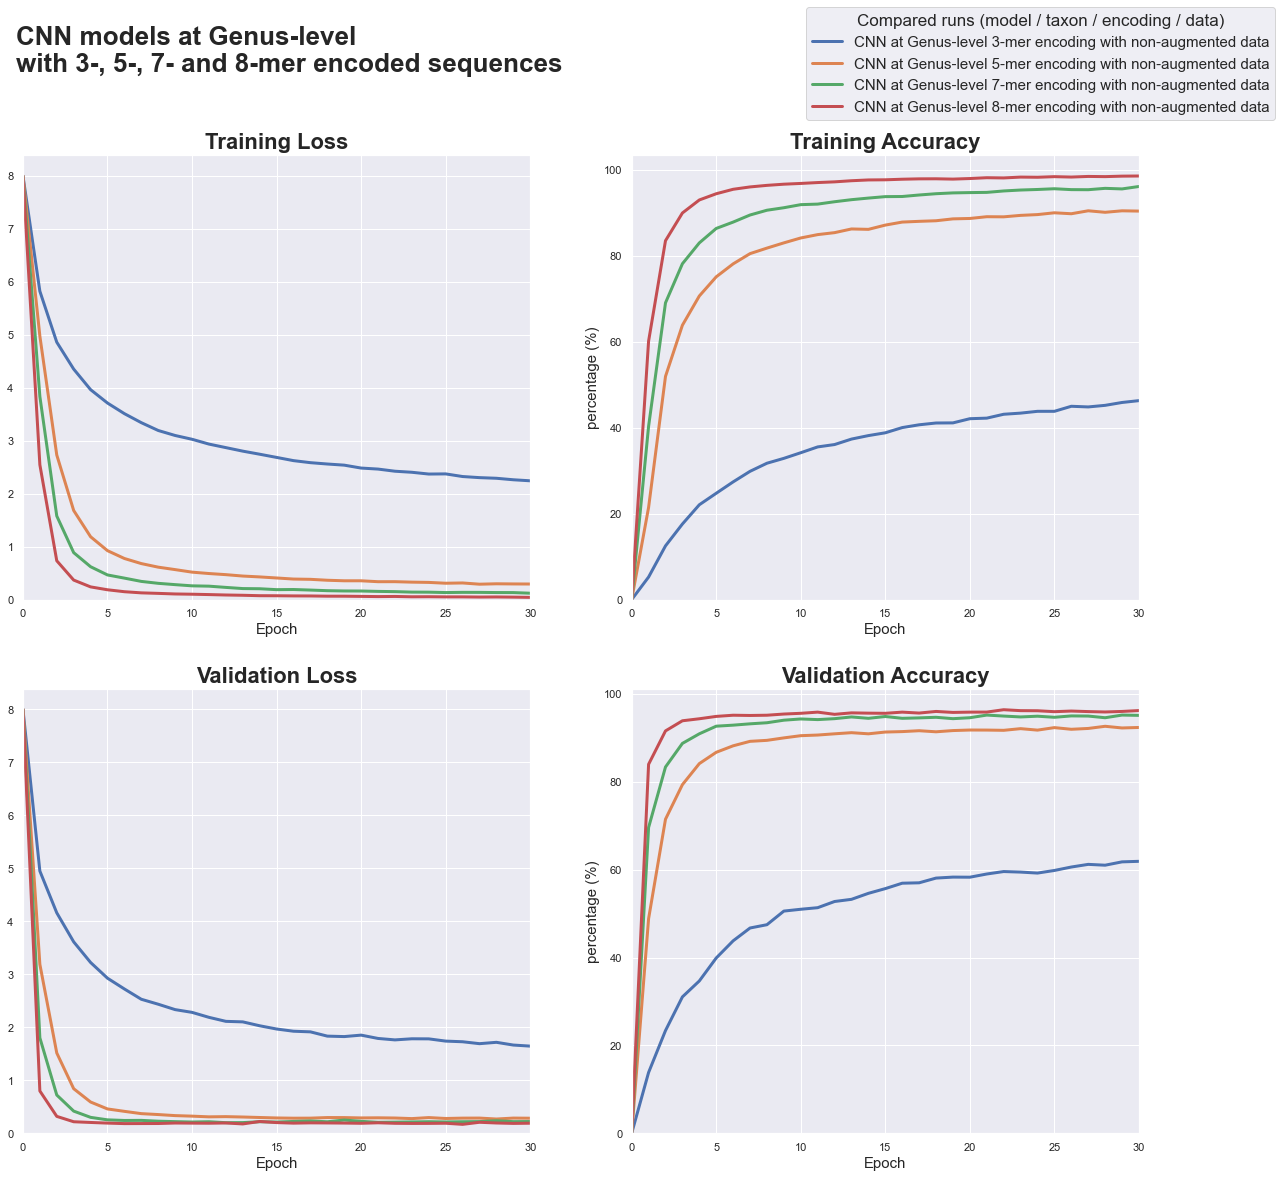

In [54]:
give_score(
    model = ['CNN'], 
    taxon = ['Genus'], 
    encoding = [
        '3-mer', '5-mer', '7-mer', '8-mer'], 
    data = ['non-augmented']
    )

plot_hist(
    histories_CNN_encoding, 
    suptitle = 'CNN models at Genus-level\nwith 3-, 5-, 7- and 8-mer encoded sequences')

**Comparing the CNN model at Genus level with 5- and 7-mer including N bases encoded sequences**

,Model,Taxon,Encoding,Data,Training time (h:m:s),Test loss,Test accuracy (%),F1-score (%),MCC
7,CNN,Genus,7-mer incl. N,non-augmented,00:08:02,0.2392,95.46,94.82,0.9540
8,CNN,Genus,7-mer,non-augmented,00:01:51,0.2188,95.24,94.64,0.9521
11,CNN,Genus,5-mer incl. N,non-augmented,00:00:40,0.2468,93.61,92.79,0.9356
14,CNN,Genus,5-mer,non-augmented,00:00:31,0.2711,92.41,91.34,0.9236


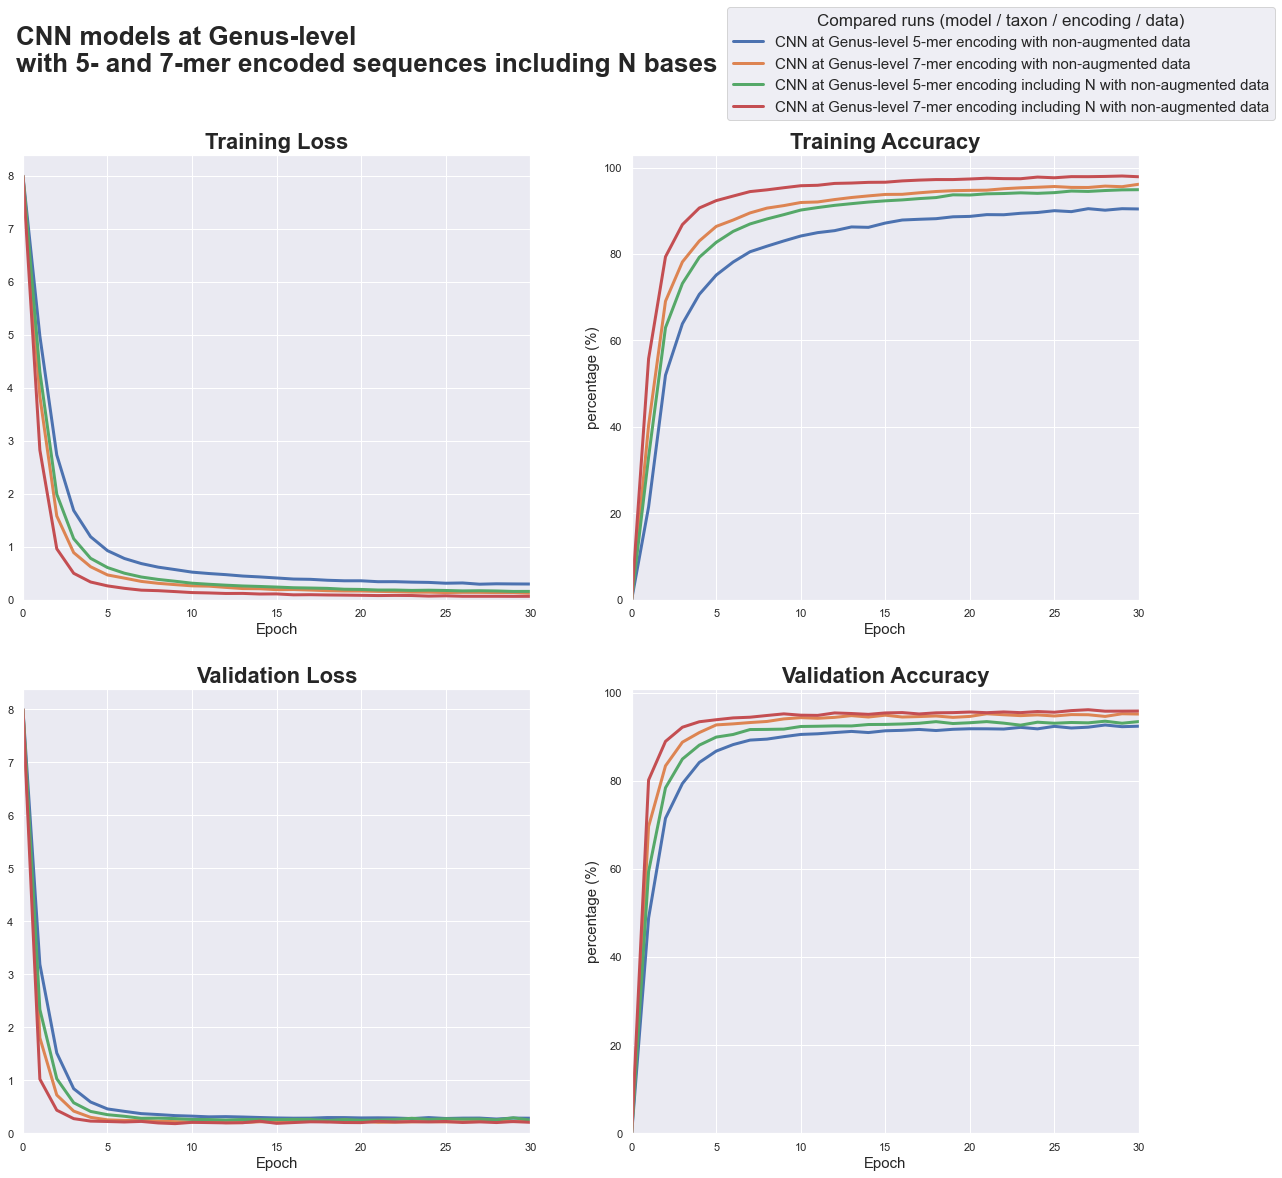

In [55]:
give_score(
    model = ['CNN'], 
    taxon = ['Genus'], 
    encoding = [
        '5-mer', '7-mer', '5-mer incl. N', '7-mer incl. N'], 
    data = ['non-augmented']
    )

plot_hist(
    histories_CNN_encodingN, 
    suptitle = 'CNN models at Genus-level\nwith 5- and 7-mer encoded sequences including N bases')

**Comparing the BiLSTM model at Genus level with regular and mutation rate adjusted one-hot-encoded sequences**



,Model,Taxon,Encoding,Data,Training time (h:m:s),Test loss,Test accuracy (%),F1-score (%),MCC
30,BiLSTM,Genus,mut. one-hot 2,non-augmented,13:21:05,1.0451,73.70,69.96,0.7351
33,BiLSTM,Genus,mut. one-hot 1,non-augmented,12:57:08,1.3654,66.89,63.19,0.6665
37,BiLSTM,Genus,regular one-hot,non-augmented,00:30:16,2.1634,50.34,43.32,0.4994


None


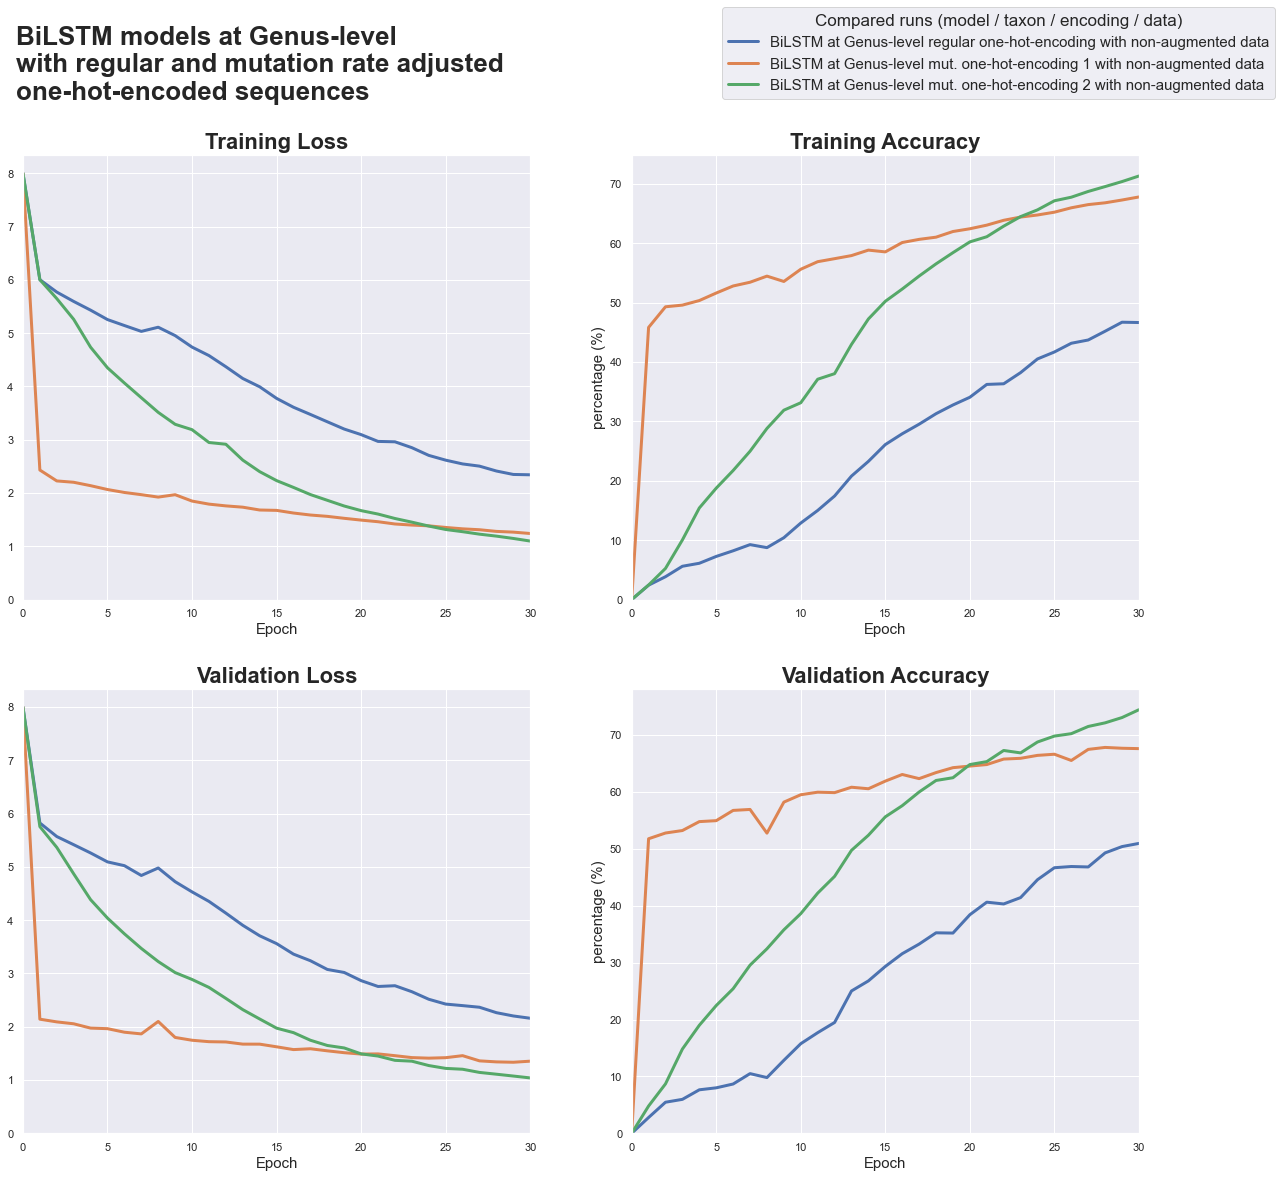

In [56]:
give_score(
    model = ['BiLSTM'], 
    taxon = ['Genus'], 
    encoding = [
        'regular one-hot', 'mut. one-hot 1', 'mut. one-hot 2'], 
    data = ['non-augmented']
    )

plot_hist(
    histories_BiLSTM_encoding, 
    suptitle = 'BiLSTM models at Genus-level\nwith regular and mutation rate adjusted\none-hot-encoded sequences')

**Comparing the ConvBiLSTM model at Genus level with regular and mutation rate adjusted one-hot-encoded sequences**



,Model,Taxon,Encoding,Data,Training time (h:m:s),Test loss,Test accuracy (%),F1-score (%),MCC
25,ConvBiLSTM,Genus,mut. one-hot 2,non-augmented,00:05:31,0.8474,82.88,81.97,0.8277
27,ConvBiLSTM,Genus,mut. one-hot 1,non-augmented,00:05:31,0.8998,80.56,79.12,0.8042
28,ConvBiLSTM,Genus,regular one-hot,non-augmented,00:05:34,0.9603,77.25,75.23,0.7709


None


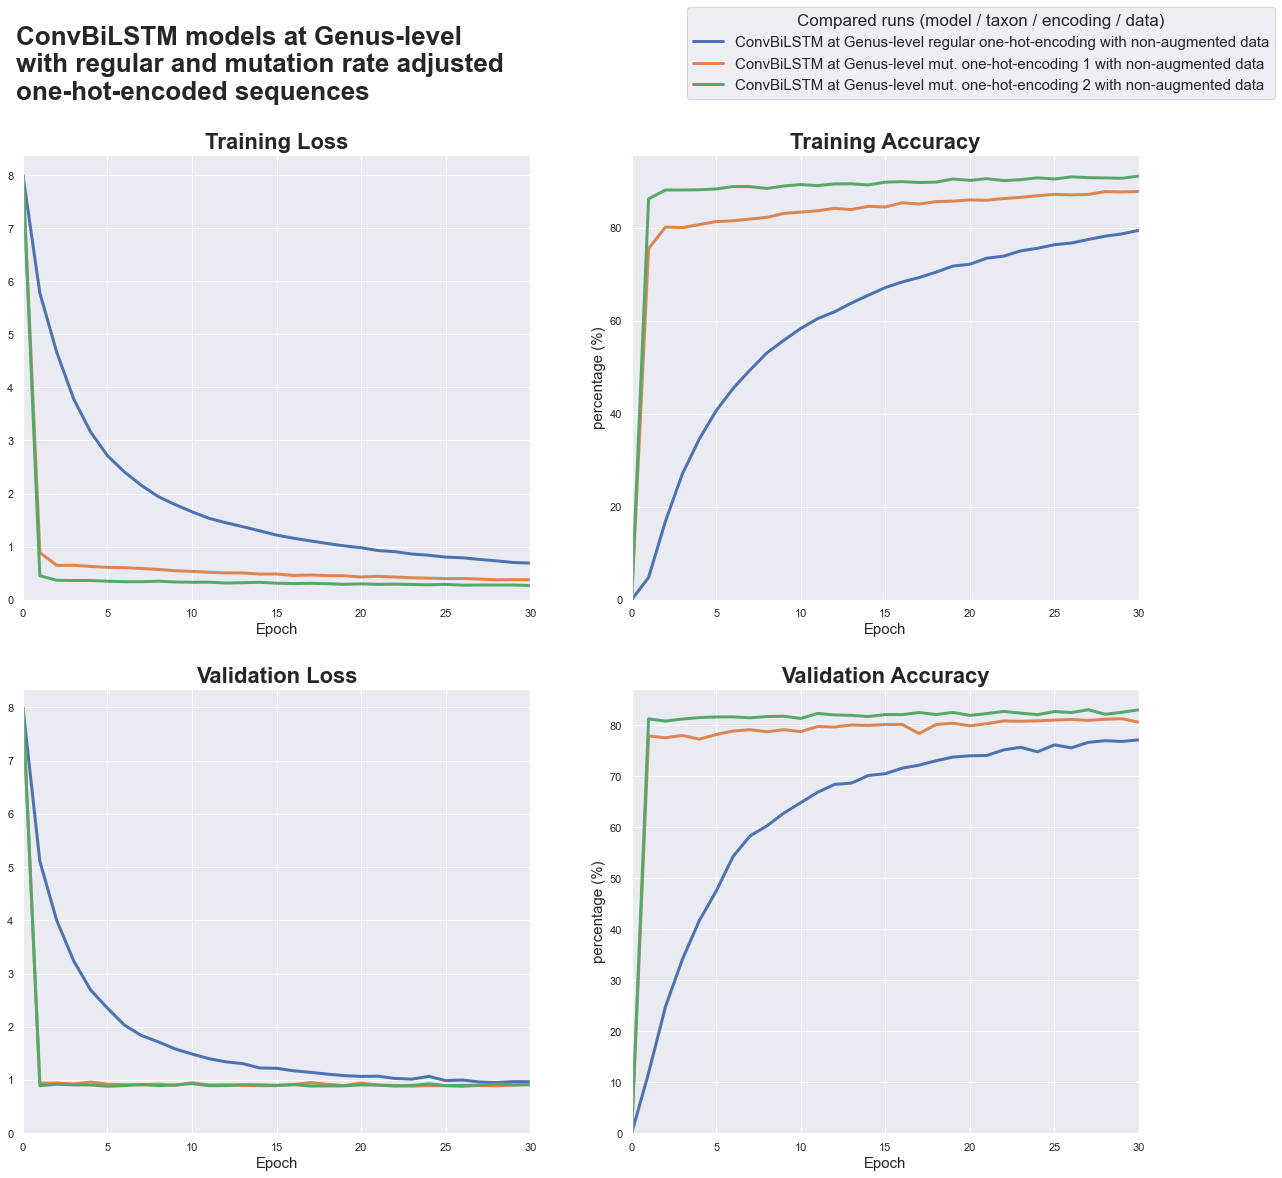

In [57]:
give_score(
    model = ['ConvBiLSTM'], 
    taxon = ['Genus'], 
    encoding = [
        'regular one-hot', 'mut. one-hot 1', 'mut. one-hot 2'], 
    data = ['non-augmented']
    )

plot_hist(
    histories_ConvBiLSTM_encoding, 
    suptitle = 'ConvBiLSTM models at Genus-level\nwith regular and mutation rate adjusted\none-hot-encoded sequences')

**Comparing the Read2Pheno model at Genus level with regular and mutation rate adjusted one-hot-encoded sequences**

,Model,Taxon,Encoding,Data,Training time (h:m:s),Test loss,Test accuracy (%),F1-score (%),MCC
20,R2P,Genus,mut. one-hot 2,non-augmented,00:17:20,0.4636,88.92,88.16,0.8884
23,R2P,Genus,mut. one-hot 1,non-augmented,00:17:19,0.5251,86.10,84.55,0.8600
36,R2P,Genus,regular one-hot,non-augmented,00:17:21,1.6091,58.65,54.58,0.5836


None


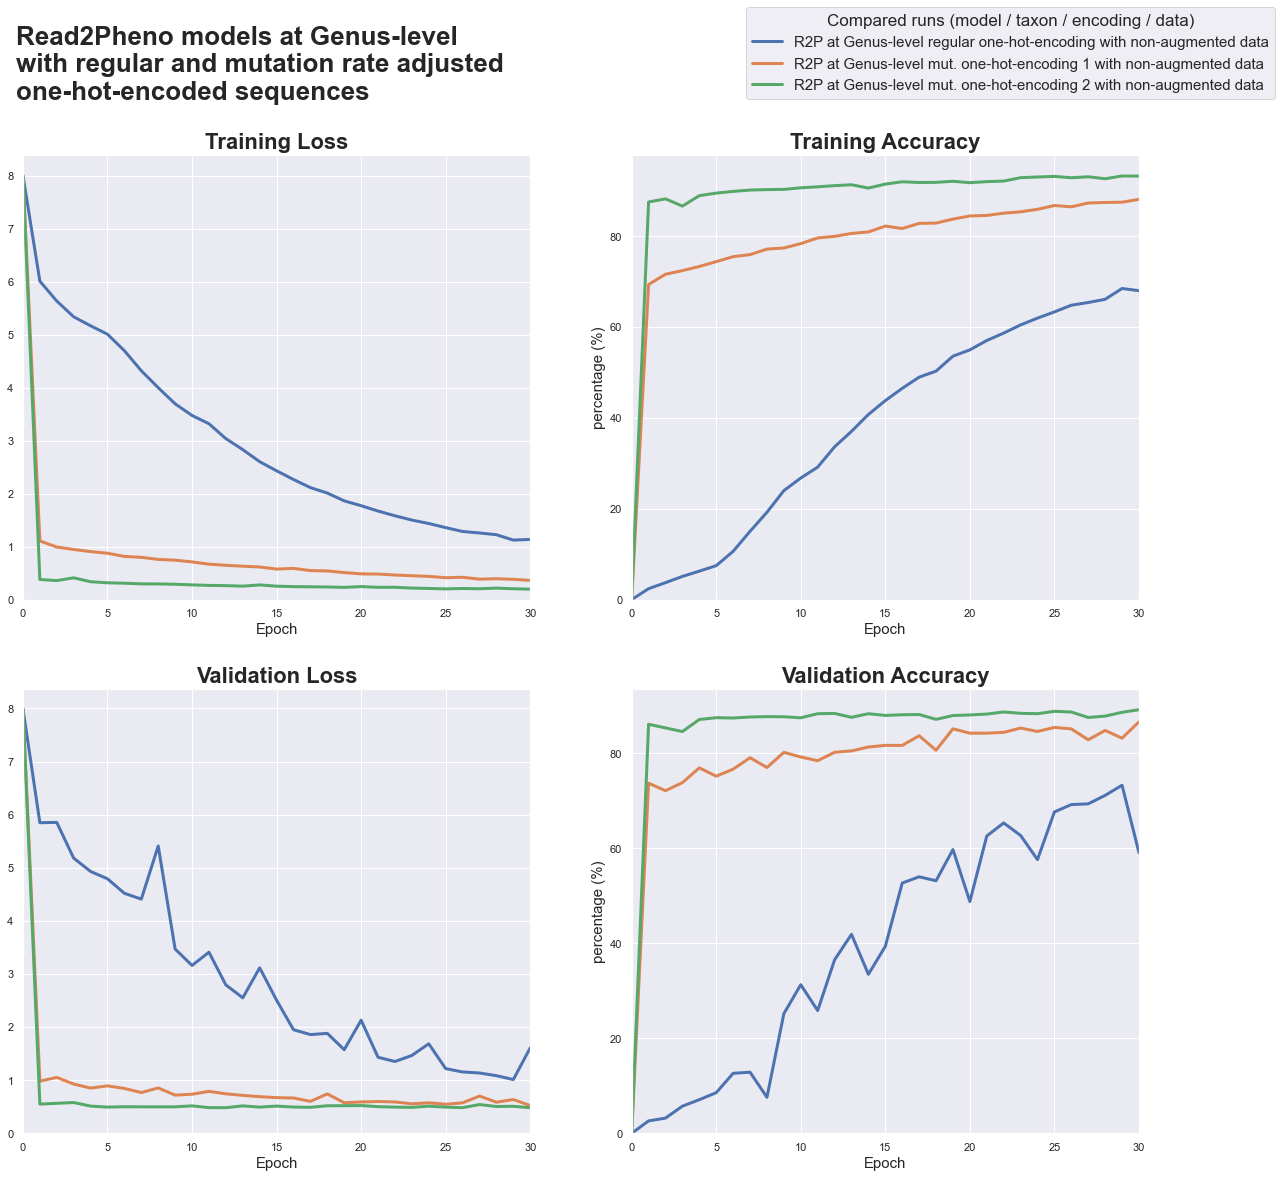

In [72]:
give_score(
    model = ['R2P'], 
    taxon = ['Genus'], 
    encoding = [
        'regular one-hot', 'mut. one-hot 1', 'mut. one-hot 2'], 
    data = ['non-augmented']
    )

plot_hist(
    histories_R2P_encoding, 
    suptitle = 'Read2Pheno models at Genus-level\nwith regular and mutation rate adjusted\none-hot-encoded sequences')

#### 2. Comparing the models' results with the regular, augmented and V-region selected data
**Comparing the CNN model at Genus level with 7-mer encoded sequences on the non-augmented and augmented data**



,Model,Taxon,Encoding,Data,Training time (h:m:s),Test loss,Test accuracy (%),F1-score (%),MCC
6,CNN,Genus,7-mer,augmented,00:04:18,0.2708,95.69,95.14,0.9566
8,CNN,Genus,7-mer,non-augmented,00:01:51,0.2188,95.24,94.64,0.9521


None


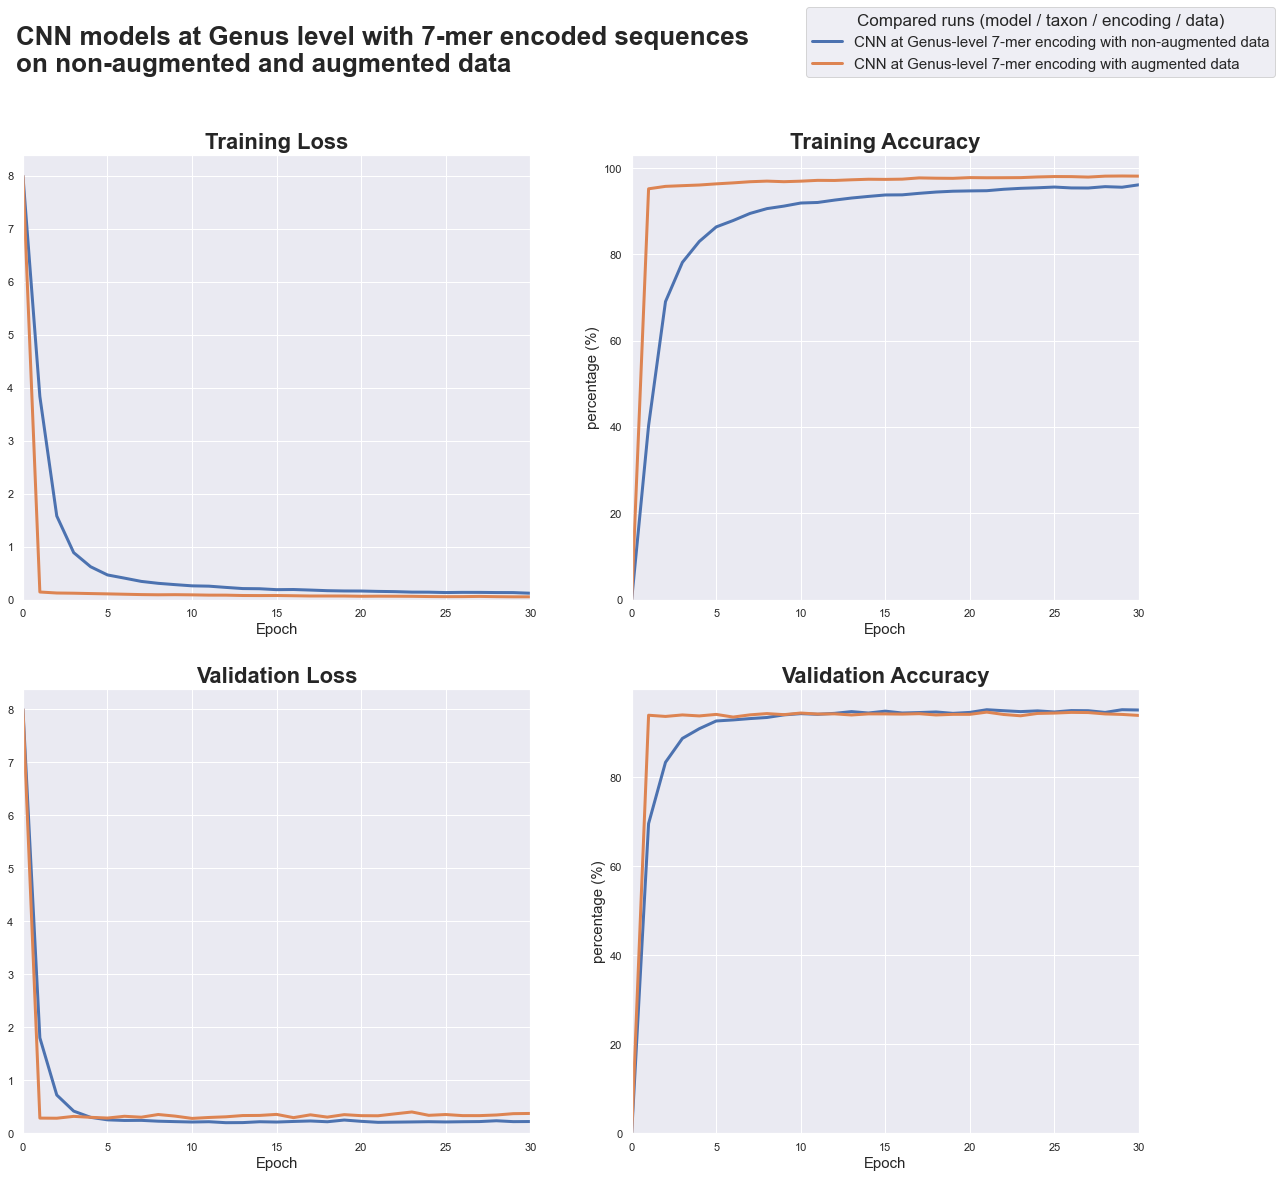

In [74]:
give_score(
    model = ['CNN'], 
    taxon = ['Genus'], 
    encoding = ['7-mer'], 
    data = ['non-augmented', 'augmented']
    )

plot_hist(
    histories_CNN_data, 
    suptitle = 'CNN models at Genus level with 7-mer encoded sequences\non non-augmented and augmented data')

**Comparing the ConvBiLSTM model at Genus level with mutation rate adjusted one-hot-encoded sequences on the non-augmented, augmented and V-region selected data**



,Model,Taxon,Encoding,Data,Training time (h:m:s),Test loss,Test accuracy (%),F1-score (%),MCC
24,ConvBiLSTM,Genus,mut. one-hot 1,augmented,00:13:12,0.9834,83.26,82.75,0.8315
25,ConvBiLSTM,Genus,mut. one-hot 2,non-augmented,00:05:31,0.8474,82.88,81.97,0.8277
26,ConvBiLSTM,Genus,mut. one-hot 2,augmented,00:13:13,0.8611,82.48,81.73,0.8236
27,ConvBiLSTM,Genus,mut. one-hot 1,non-augmented,00:05:31,0.8998,80.56,79.12,0.8042


None


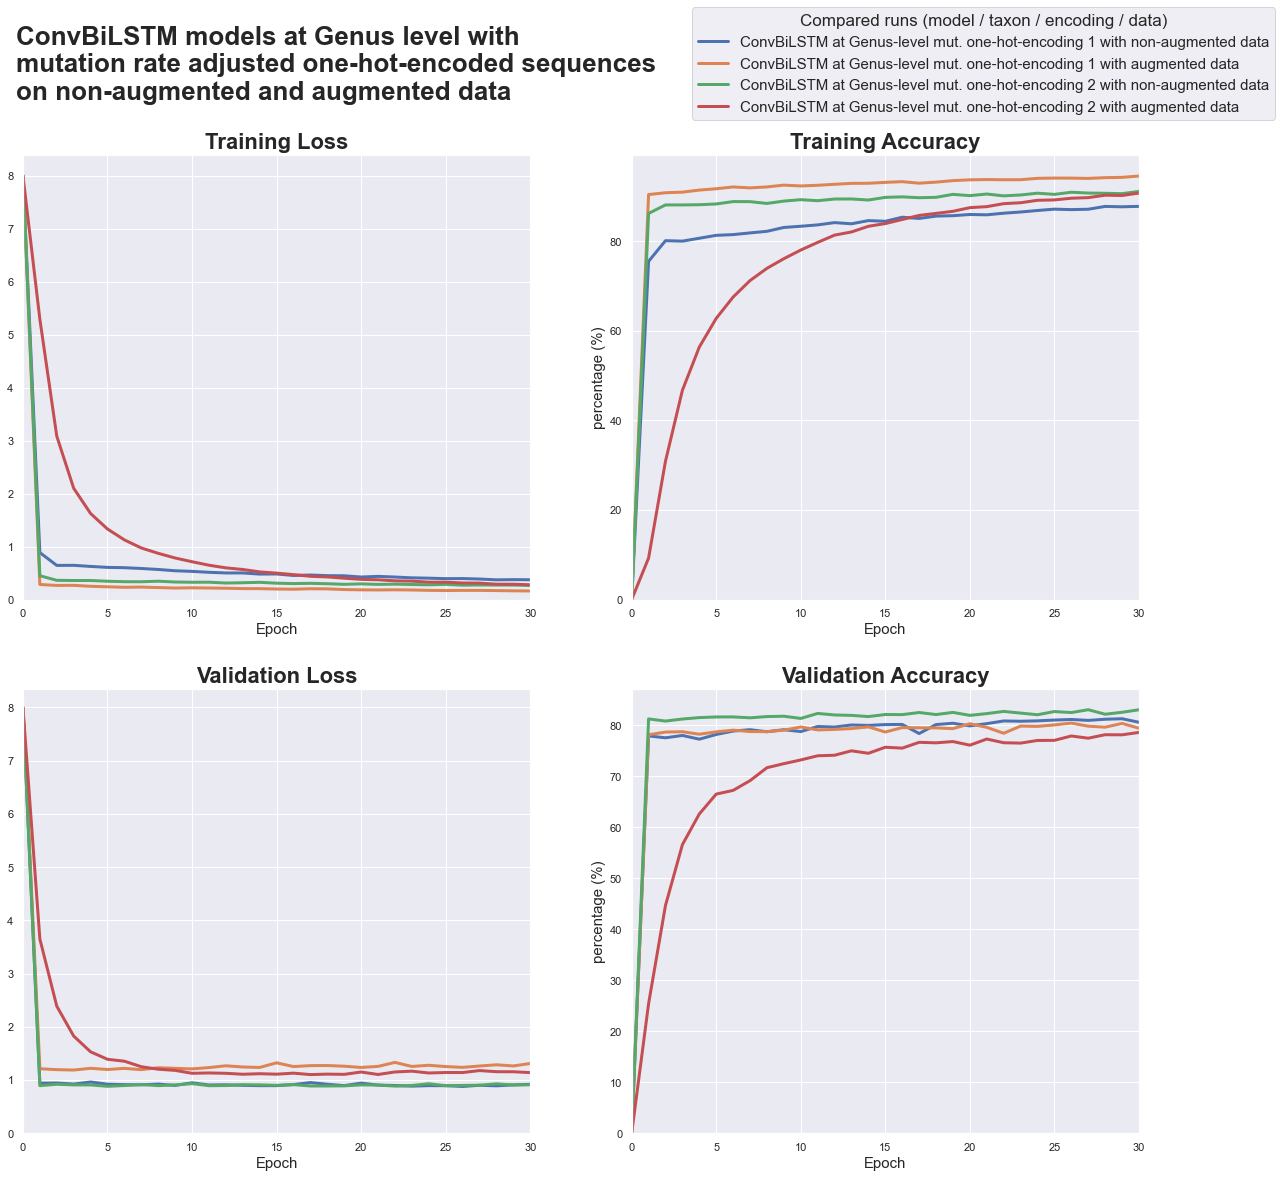

In [82]:
give_score(
    model = ['ConvBiLSTM'], 
    taxon = ['Genus'], 
    encoding = ['mut. one-hot 1', 'mut. one-hot 2'], 
    data = ['non-augmented', 'augmented']
    )

plot_hist(
    histories_ConvBiLSTM_data, 
    suptitle = 'ConvBiLSTM models at Genus level with\nmutation rate adjusted one-hot-encoded sequences\non non-augmented and augmented data')

**Comparing the Read2Pheno model at Genus level with mutation rate adjusted one-hot-encoded sequences on the non-augmented, augmented and V-region selected data**



,Model,Taxon,Encoding,Data,Training time (h:m:s),Test loss,Test accuracy (%),F1-score (%),MCC
16,R2P,Genus,mut. one-hot 1,augmented,00:41:42,0.4932,90.60,90.10,0.9053
20,R2P,Genus,mut. one-hot 2,non-augmented,00:17:20,0.4636,88.92,88.16,0.8884
22,R2P,Genus,mut. one-hot 2,augmented,00:42:01,0.6082,87.20,86.68,0.8712
23,R2P,Genus,mut. one-hot 1,non-augmented,00:17:19,0.5251,86.10,84.55,0.8600


None


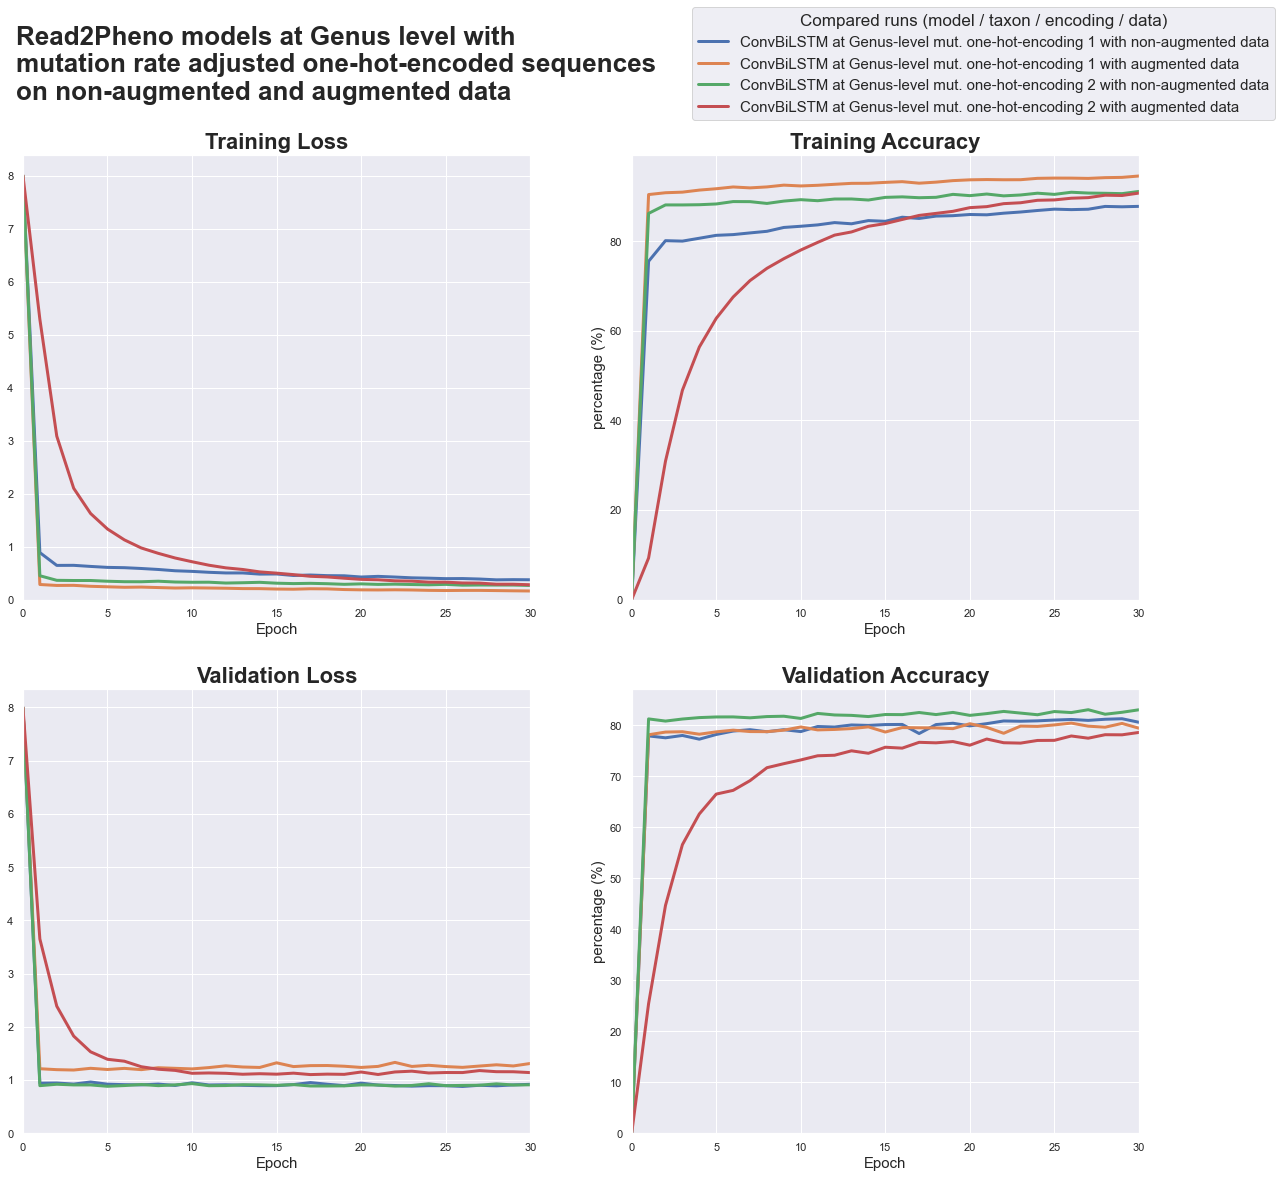

In [83]:
give_score(
    model = ['R2P'], 
    taxon = ['Genus'], 
    encoding = ['mut. one-hot 1', 'mut. one-hot 2'], 
    data = ['non-augmented', 'augmented']
    )

plot_hist(
    histories_ConvBiLSTM_data, 
    suptitle = 'Read2Pheno models at Genus level with\nmutation rate adjusted one-hot-encoded sequences\non non-augmented and augmented data')

#### 4. Comparing the models with each other
**Comparing the RDP / CNN / BiLSTM / ConvBiLSTM / Read2Pheno models at species level on the non-augmented data**



,Model,Taxon,Encoding,Data,Training time (h:m:s),Test loss,Test accuracy (%),F1-score (%),MCC
17,RDP,Species,8-mer full tax.,non-augmented,00:00:31,NaN,89.79,89.82,0.8975
18,RDP,Species,8-mer only spe.,non-augmented,00:00:31,NaN,89.79,89.82,0.8975
19,CNN,Species,7-mer,non-augmented,00:01:50,0.4514,89.29,87.53,0.8924
29,R2P,Species,mut. one-hot 2,non-augmented,00:17:28,0.9856,74.66,71.25,0.7454
34,ConvBiLSTM,Species,mut. one-hot 2,non-augmented,00:05:33,1.7774,62.63,59.14,0.6245


None


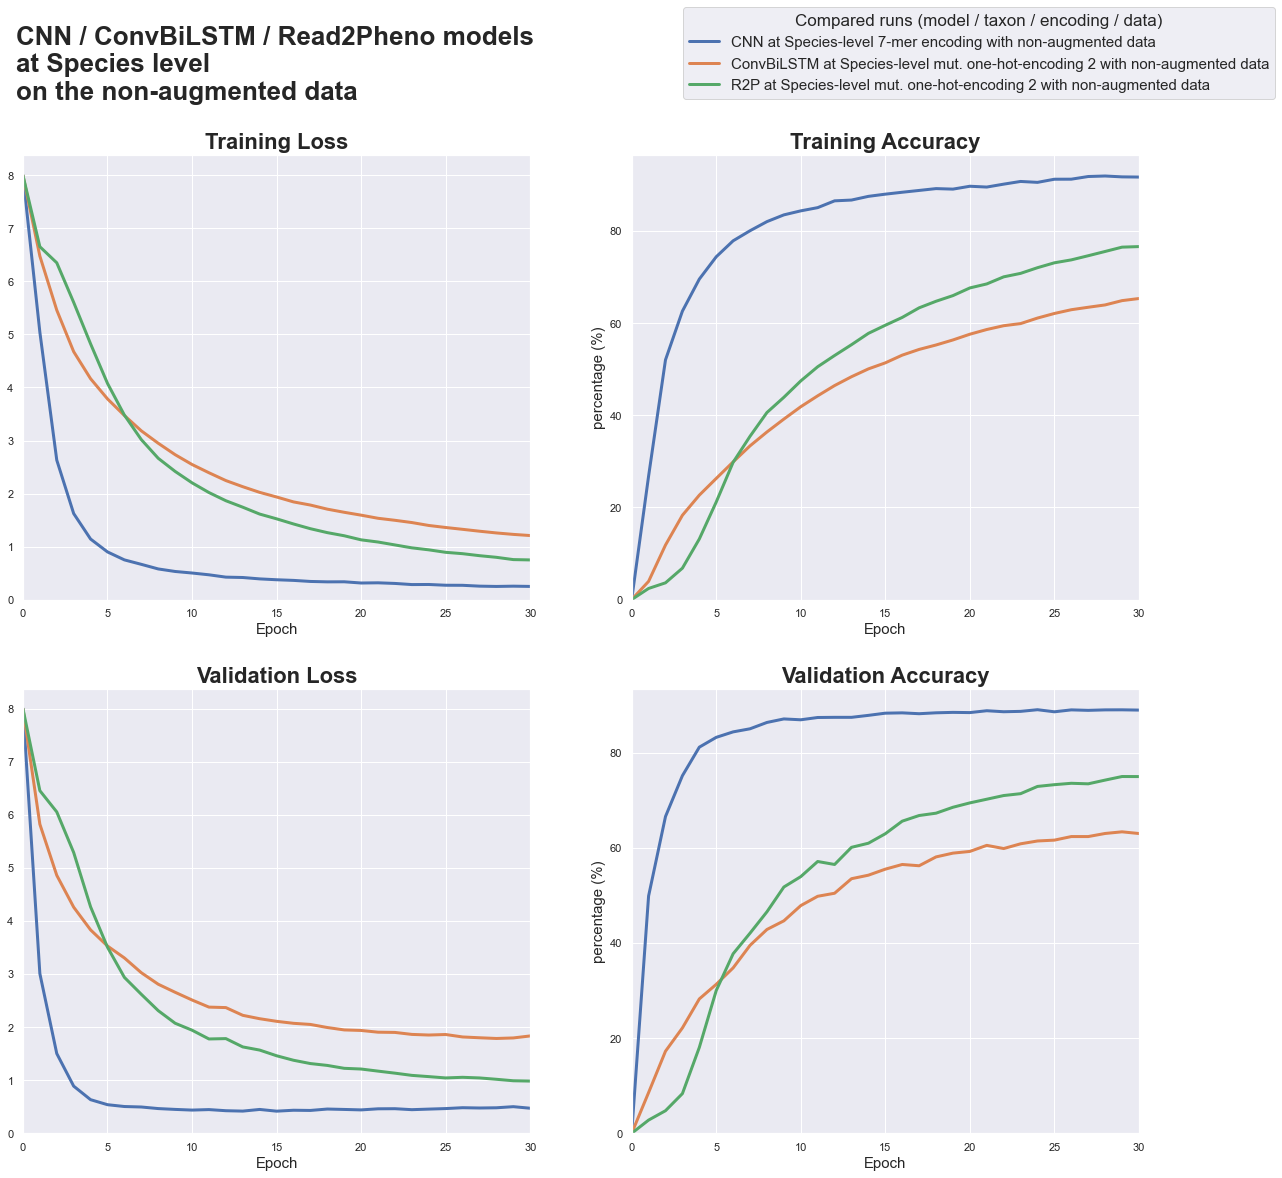

In [88]:
give_score(
    model = ['RDP', 'CNN', 'ConvBiLSTM', 'R2P'], 
    taxon = ['Species'], 
    encoding = ['8-mer full tax.', '8-mer only spe.', '7-mer', 'mut. one-hot 2'], 
    data = ['non-augmented']
    )

plot_hist(
    histories_models_spe, 
    suptitle = 'CNN / ConvBiLSTM / Read2Pheno models\nat Species level\non the non-augmented data')

**Comparing the RDP / CNN / BiLSTM / ConvBiLSTM / Read2Pheno models at genus level on the non-augmented data**



,Model,Taxon,Encoding,Data,Training time (h:m:s),Test loss,Test accuracy (%),F1-score (%),MCC
3,CNN,Genus,8-mer,non-augmented,00:06:36,0.1897,96.33,95.88,0.9630
4,RDP,Genus,8-mer full tax.,non-augmented,00:00:31,NaN,96.16,96.22,0.9614
8,CNN,Genus,7-mer,non-augmented,00:01:51,0.2188,95.24,94.64,0.9521
9,RDP,Genus,8-mer only gen.,non-augmented,00:00:28,NaN,94.73,94.92,0.9471
20,R2P,Genus,mut. one-hot 2,non-augmented,00:17:20,0.4636,88.92,88.16,0.8884
25,ConvBiLSTM,Genus,mut. one-hot 2,non-augmented,00:05:31,0.8474,82.88,81.97,0.8277
30,BiLSTM,Genus,mut. one-hot 2,non-augmented,13:21:05,1.0451,73.70,69.96,0.7351


None


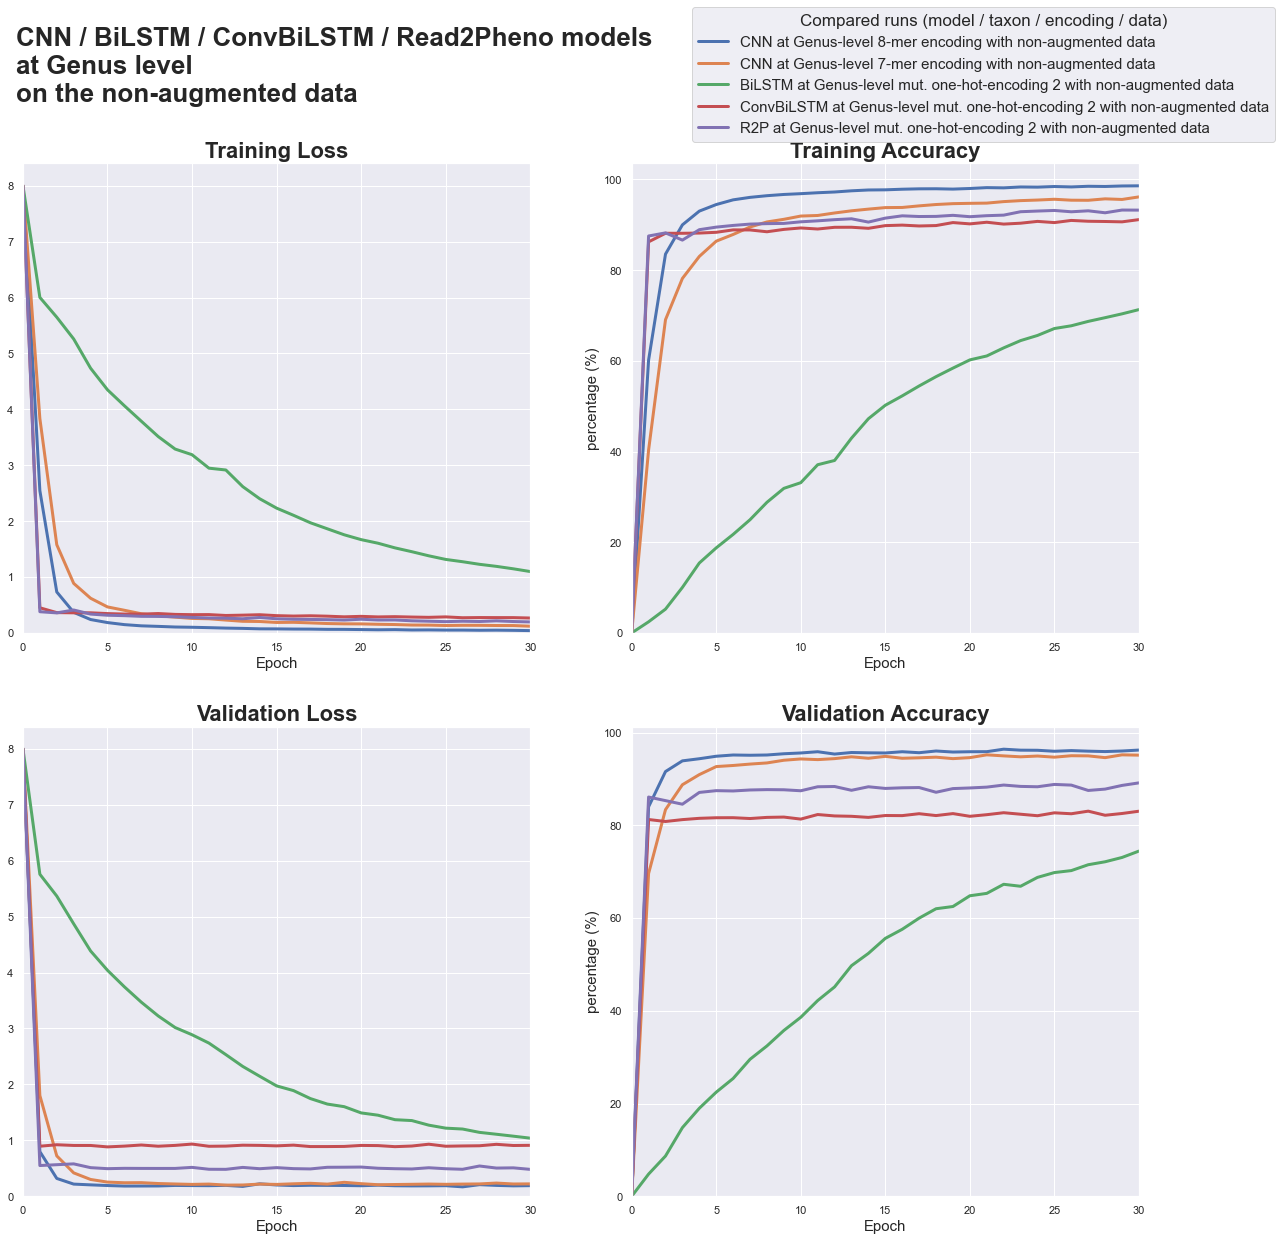

In [99]:
give_score(
    model = ['RDP', 'CNN', 'BiLSTM', 'ConvBiLSTM', 'R2P'], 
    taxon = ['Genus'], 
    encoding = ['8-mer full tax.', '8-mer only gen.', '7-mer', '8-mer', 'mut. one-hot 2'], 
    data = ['non-augmented']
    )

plot_hist(
    histories_models_gen, 
    suptitle = 'CNN / BiLSTM / ConvBiLSTM / Read2Pheno models\nat Genus level\non the non-augmented data')

**Comparing the RDP / CNN / BiLSTM / ConvBiLSTM / Read2Pheno models at family level on the non-augmented data**



,Model,Taxon,Encoding,Data,Training time (h:m:s),Test loss,Test accuracy (%),F1-score (%),MCC
0,RDP,Family,8-mer full tax.,non-augmented,00:00:31,NaN,99.13,99.12,0.9911
1,CNN,Family,7-mer,non-augmented,00:01:48,0.0936,98.79,98.71,0.9877
2,RDP,Family,8-mer only fam.,non-augmented,00:00:25,NaN,98.34,98.37,0.9832
12,R2P,Family,mut. one-hot 2,non-augmented,00:17:25,0.2777,93.33,92.94,0.9322
21,ConvBiLSTM,Family,mut. one-hot 2,non-augmented,00:05:32,0.4699,87.60,87.03,0.8740


None


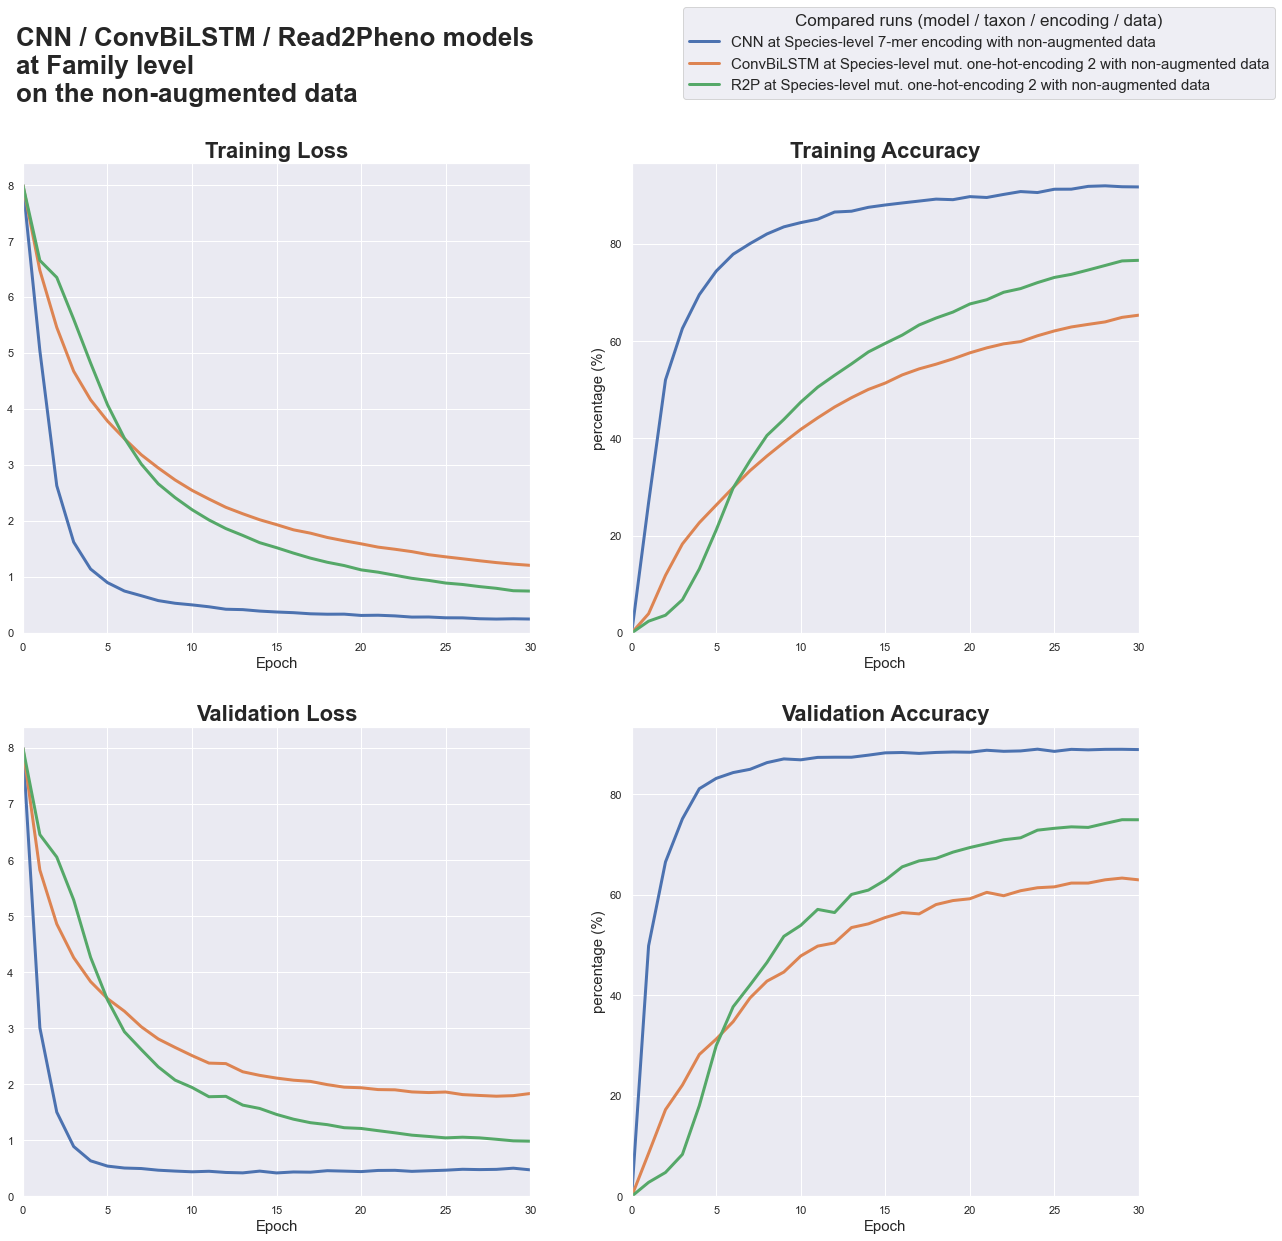

In [100]:
give_score(
    model = ['RDP', 'CNN', 'ConvBiLSTM', 'R2P'], 
    taxon = ['Family'], 
    encoding = ['8-mer full tax.', '8-mer only fam.', '7-mer', 'mut. one-hot 2'], 
    data = ['non-augmented']
    )

plot_hist(
    histories_models_spe, 
    suptitle = 'CNN / ConvBiLSTM / Read2Pheno models\nat Family level\non the non-augmented data')

**Comparing the RDP / CNN / BiLSTM / ConvBiLSTM / Read2Pheno models on the augmented data**



,Model,Taxon,Encoding,Data,Training time (h:m:s),Test loss,Test accuracy (%),F1-score (%),MCC
5,RDP,Genus,8-mer full tax.,augmented,00:01:06,NaN,95.85,95.85,0.9582
6,CNN,Genus,7-mer,augmented,00:04:18,0.2708,95.69,95.14,0.9566
10,RDP,Genus,8-mer only gen.,augmented,00:01:03,NaN,94.58,94.65,0.9456
16,R2P,Genus,mut. one-hot 1,augmented,00:41:42,0.4932,90.60,90.10,0.9053
24,ConvBiLSTM,Genus,mut. one-hot 1,augmented,00:13:12,0.9834,83.26,82.75,0.8315


None


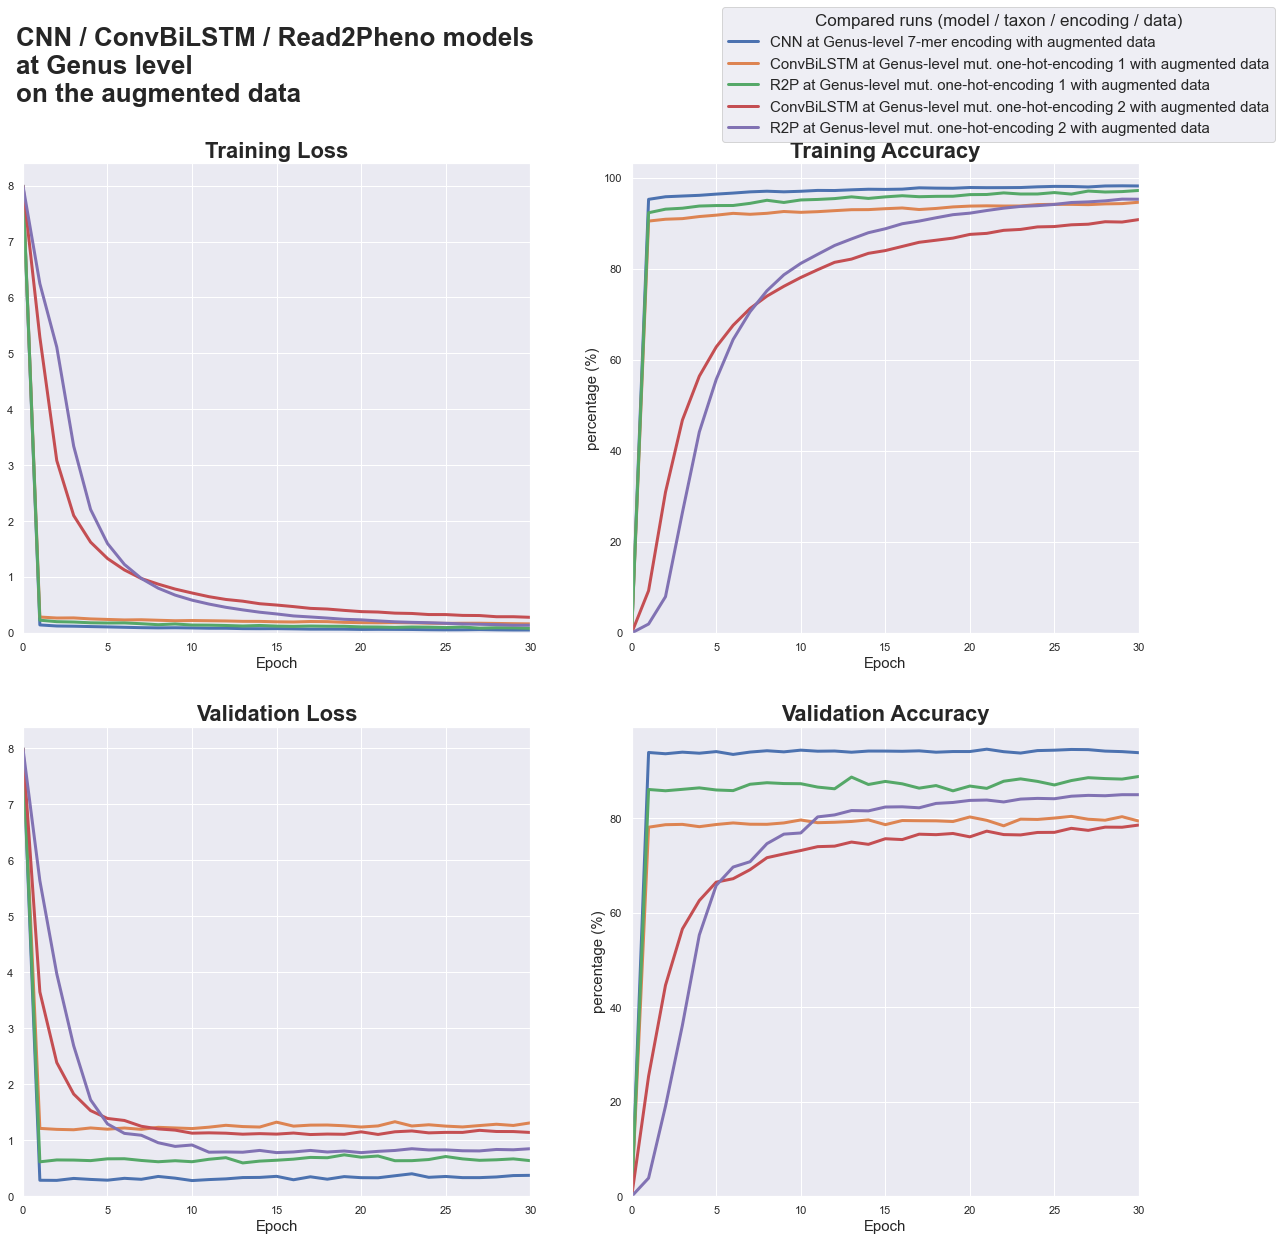

In [102]:
give_score(
    model = ['RDP', 'CNN', 'ConvBiLSTM', 'R2P'], 
    taxon = ['Genus'], 
    encoding = ['8-mer full tax.', '8-mer only gen.', '7-mer', 'mut. one-hot 1'], 
    data = ['augmented']
    )

plot_hist(
    histories_models_a, 
    suptitle = 'CNN / ConvBiLSTM / Read2Pheno models\nat Genus level\non the augmented data')